<a href="https://colab.research.google.com/github/mollybocock/AI-Assignment-1/blob/main/ExplainableTechniques2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI CODE DEMO
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/interpretable-ml-example-notebooks/regression-interpretability.ipynb)

In [272]:
# AIPI 590 - XAI | Assignment #4
### ICE, ALE, and PDP Plots
### Molly Bocock
###Summary: The dataset "Individual Age of Death and Related Factors" was downloaded from Kaggle. The assumptions for linearity, homoskedasticity, normality, and independence were tested
###before building a GAM. PDP, ICE, and ALE plots were desgined to show the data. It was observed that weight, cholesterol, and drinks per week are most strongly correlated to life expectany.
###surprisingly, the higher the cholesterol the better the age outcome.

https://colab.research.google.com/github/mollybocock/blob/main/ExplainableTechniques2.ipynb



SyntaxError: invalid syntax (<ipython-input-272-b4255e3c4a87>, line 8)

#Import Libraries



Source for the code below:
https://claude.site/artifacts/86a4a5f2-da8b-4640-8d03-b314fcd777b7

As well as "Factors Influencing Age of Death Analysis" by Brian Risk, 01/26/2025 https://www.kaggle.com/code/devraai/factors-influencing-age-of-death-analysis

Claude Sonnet was extremely helpful when getting the dataset. It gave me code wiht a "browse" button which solved a lot of the setup issues I ran into the first time I used Kaggle, where I was not importing the correct CSV.

In [56]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from google.colab import files
from sklearn.preprocessing import StandardScaler

# Ensure inline plotting
%matplotlib inline

# Import json if not already imported
import json

# Upload and load your data
uploaded = files.upload()  # This will show an upload button
print("Files uploaded:", uploaded.keys())

# Specifically look for the JSON file
file_name = [name for name in uploaded.keys() if name.endswith('.json')][0]
print("Using file:", file_name)

# Read the JSON file
print("Reading JSON file...")
with open(file_name) as f:
    data = json.load(f)
df = pd.DataFrame(data)

# Check if DataFrame was created
if 'df' in locals():
    print("DataFrame created successfully")
    print("Shape of DataFrame:", df.shape)
    print("\nFirst few rows:")
    display(df.head())
else:
    print("DataFrame was not created")

Saving data.json to data.json
Saving archive(3).zip to archive(3).zip
Files uploaded: dict_keys(['data.json', 'archive(3).zip'])
Using file: data.json
Reading JSON file...
DataFrame created successfully
Shape of DataFrame: (10000, 24)

First few rows:


age  weight sex  height  sys_bp smoker nic_other  num_meds  occup_danger  \
0  100     219   m      74     136      n         n         0             1   
1   66     242   m      73     111      n         n         0             1   
2   31     197   f      65     112      n         n         7             1   
3   42     244   f      69     127      n         n         1             2   
4   93     183   f      63      91      y         n         2             3   

   ls_danger  ... addiction major_surgery_num diabetes  hds cholesterol  \
0          1  ...         n                 0        n    y         203   
1          1  ...         y                 0        n    n         228   
2          2  ...         y                 3        n    y         183   
3          3  ...         n                 2        n    y         228   
4          3  ...         y                 2        n    n         169   

   asthma immune_defic family_cancer  family_heart_disease family_cholesterol  
0       n            n             y                     n                  y  
1       n            n             n                     n                  n  
2       n            n             n                     n                  n  
3       n            n             n                     n                  n  
4       n            n             n                     n                  n  

[5 rows x 24 columns]

# Data Cleaning

In [96]:

# Display basic information about the dataset
df.info()

# Check for missing values
df.isnull().sum()

#source: "Factors Influencing Age of Death Analysis" by Brian Risk, 01/26/2025 https://www.kaggle.com/code/devraai/factors-influencing-age-of-death-analysis


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   age                     10000 non-null  int64
 1   weight                  10000 non-null  int64
 2   height                  10000 non-null  int64
 3   sys_bp                  10000 non-null  int64
 4   num_meds                10000 non-null  int64
 5   occup_danger            10000 non-null  int64
 6   ls_danger               10000 non-null  int64
 7   drinks_aweek            10000 non-null  int64
 8   major_surgery_num       10000 non-null  int64
 9   cholesterol             10000 non-null  int64
 10  sex_m                   10000 non-null  bool 
 11  smoker_y                10000 non-null  bool 
 12  nic_other_y             10000 non-null  bool 
 13  cannabis_y              10000 non-null  bool 
 14  opioids_y               10000 non-null  bool 
 15  other_drugs_y       

age                       0
weight                    0
height                    0
sys_bp                    0
num_meds                  0
occup_danger              0
ls_danger                 0
drinks_aweek              0
major_surgery_num         0
cholesterol               0
sex_m                     0
smoker_y                  0
nic_other_y               0
cannabis_y                0
opioids_y                 0
other_drugs_y             0
addiction_y               0
diabetes_y                0
hds_y                     0
asthma_y                  0
immune_defic_y            0
family_cancer_y           0
family_heart_disease_y    0
family_cholesterol_y      0
dtype: int64

In [97]:
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Check the data types again
df.dtypes

#Source: "Factors Influencing Age of Death Analysis" by Brian Risk, 01/26/2025 https://www.kaggle.com/code/devraai/factors-influencing-age-of-death-analysis


#This code automatically finds all categorical (object) columns, converts them all to dummy variables in one step, and handles both binary (y/n) and multi-category variables (like height) at once. Breaking it down step by step would look like:
# Step 2: Convert binary variables
#for col in binary_cols:
    #df[col] = df[col].map({'y': 1, 'n': 0})

# Step 3: One-hot encode categorical variables
#df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 4: Verify all conversions worked
#print("\nUpdated data types:\n", df.dtypes)

#Explanation Source: Generated with Claude 3.5 Sonnet 02/02/2025 at 2:34 pm




age                       int64
weight                    int64
height                    int64
sys_bp                    int64
num_meds                  int64
occup_danger              int64
ls_danger                 int64
drinks_aweek              int64
major_surgery_num         int64
cholesterol               int64
sex_m                      bool
smoker_y                   bool
nic_other_y                bool
cannabis_y                 bool
opioids_y                  bool
other_drugs_y              bool
addiction_y                bool
diabetes_y                 bool
hds_y                      bool
asthma_y                   bool
immune_defic_y             bool
family_cancer_y            bool
family_heart_disease_y     bool
family_cholesterol_y       bool
dtype: object

In [98]:
from sklearn.preprocessing import OneHotEncoder

# Identify numeric and categorical columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object', 'bool']).columns

# Print to verify
print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))

# Ensure all categorical variables are properly encoded
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Changed from sparse=False
categorical_encoded = encoder.fit_transform(df[categorical_features])
categorical_encoded_df = pd.DataFrame(
    categorical_encoded,
    columns=encoder.get_feature_names_out(categorical_features)
)

# Combine numeric and encoded categorical features
X = pd.concat([
    df[numeric_features],
    categorical_encoded_df
], axis=1)

Numeric features: ['age', 'weight', 'height', 'sys_bp', 'num_meds', 'occup_danger', 'ls_danger', 'drinks_aweek', 'major_surgery_num', 'cholesterol']
Categorical features: ['sex_m', 'smoker_y', 'nic_other_y', 'cannabis_y', 'opioids_y', 'other_drugs_y', 'addiction_y', 'diabetes_y', 'hds_y', 'asthma_y', 'immune_defic_y', 'family_cancer_y', 'family_heart_disease_y', 'family_cholesterol_y']


# Exploratory Data Analysis


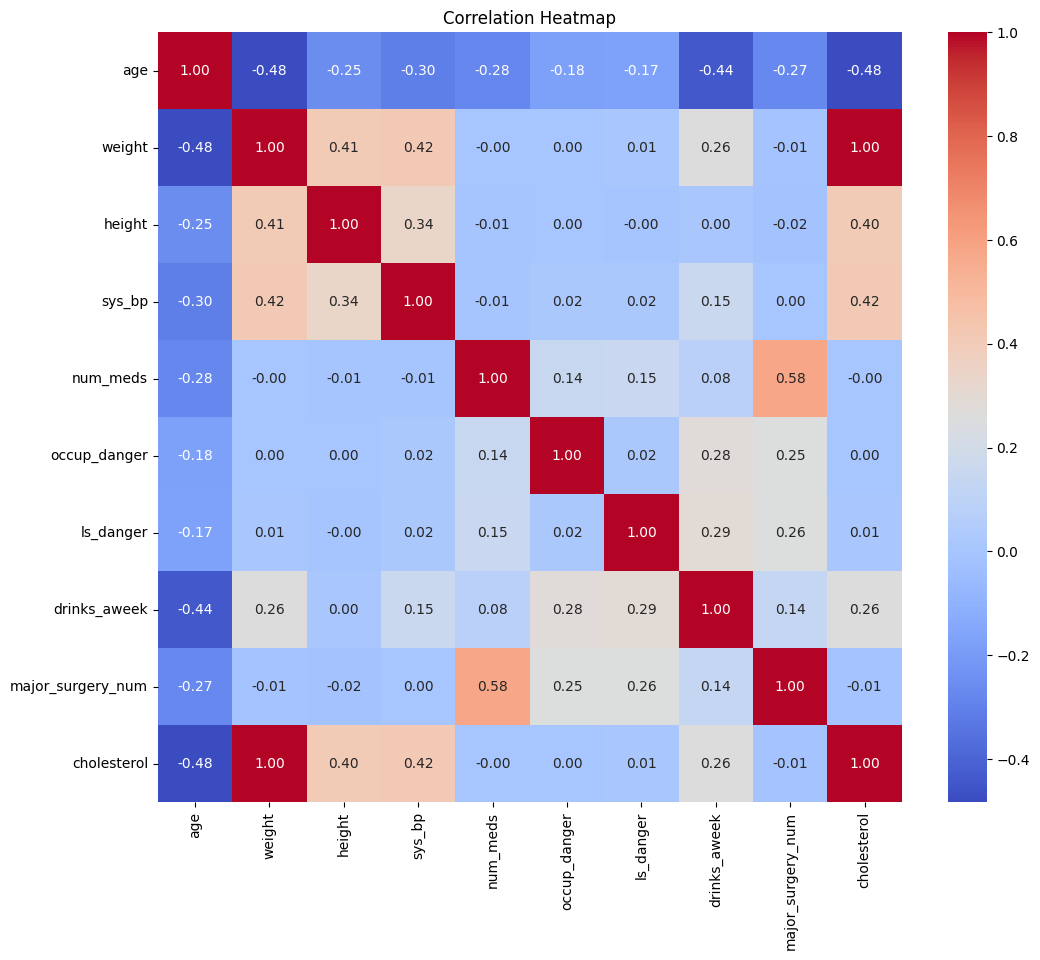

In [99]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Code source: "Factors Influencing Age of Death Analysis" by Brian Risk, 01/26/2025 https://www.kaggle.com/code/devraai/factors-influencing-age-of-death-analysis

The Correlation Heat Map is used to show the strength and direction of realtionshios between numeric variables. From this map, it appears that age has strong negative correlations with weight, drinks per week, and cholsterol. Weight and cholesterol have a perfect positive correclation.

In [100]:
# Include binary variables in analysis
binary_cols = [col for col in df.columns if df[col].dtype == 'bool']
print("Binary feature correlations with age:")
for col in binary_cols:
    correlation = df[col].corr(df['age'])
    print(f"{col}: {correlation:.3f}")


Binary feature correlations with age:
sex_m: -0.286
smoker_y: -0.117
nic_other_y: -0.054
cannabis_y: -0.013
opioids_y: -0.197
other_drugs_y: -0.083
addiction_y: -0.469
diabetes_y: 0.006
hds_y: -0.431
asthma_y: -0.031
immune_defic_y: -0.152
family_cancer_y: -0.091
family_heart_disease_y: -0.076
family_cholesterol_y: -0.016


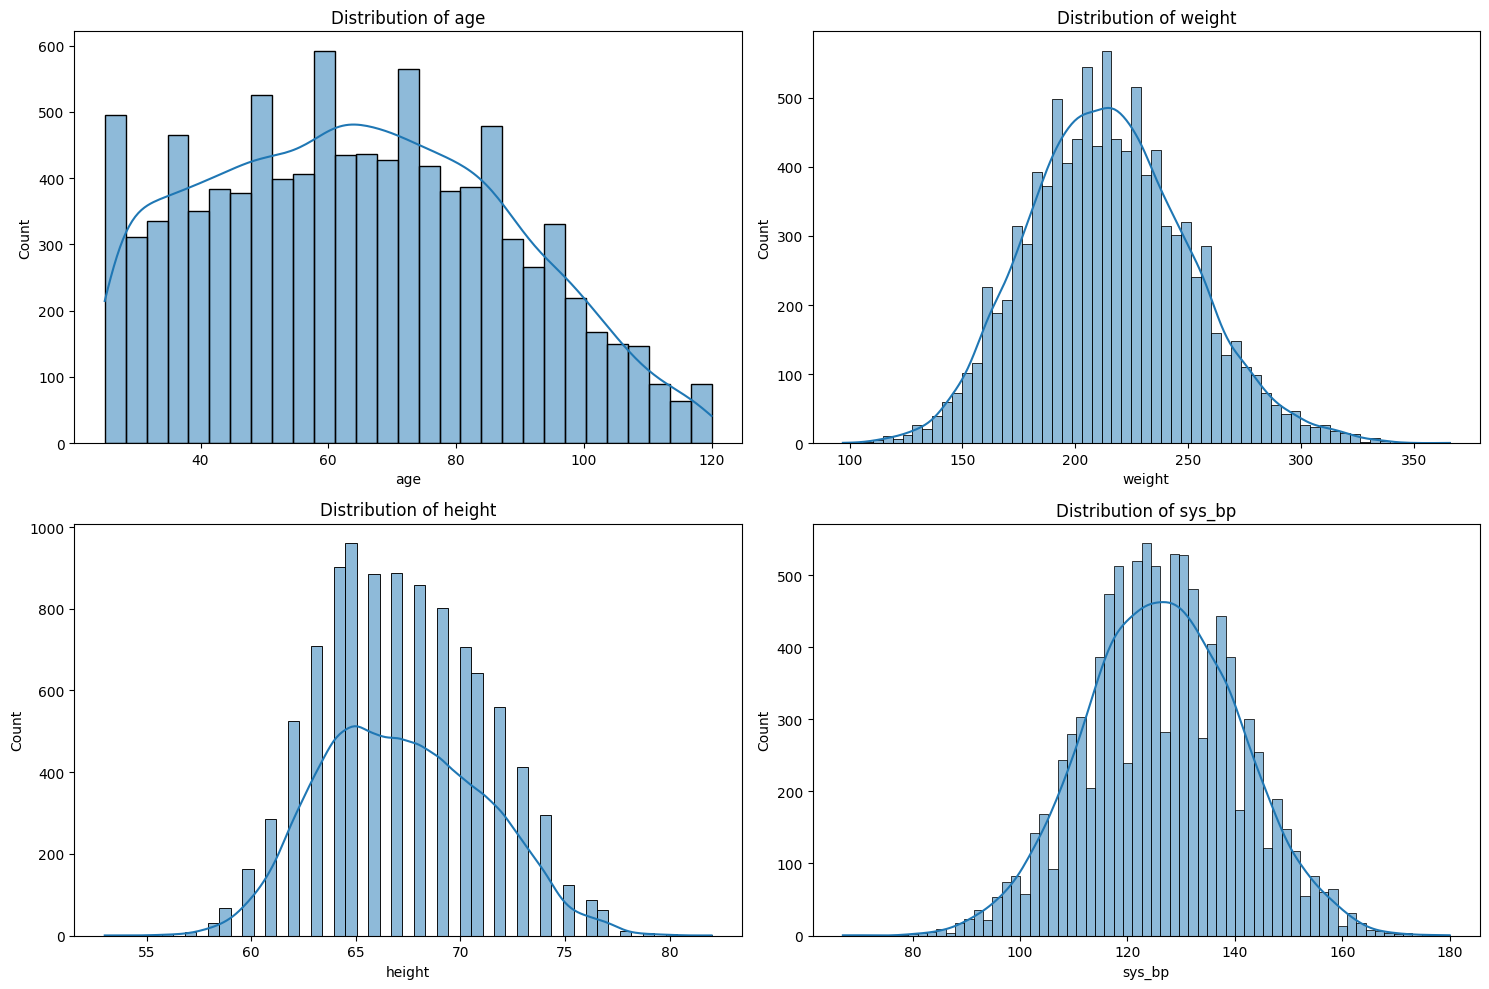

In [101]:
# Visualize distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(['age', 'weight', 'height', 'sys_bp']):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()



Source: code generated with Claude Sonnet 3.5 02/04/2025 at 2:49 pm

The ages range from around 20 years old to 120 years old. It is slightly skewed right. The wieght is from a little under 100 to 360 (?) pounds, and that distribution looks normal. Systolic bp also appears to follow a normal distribution.


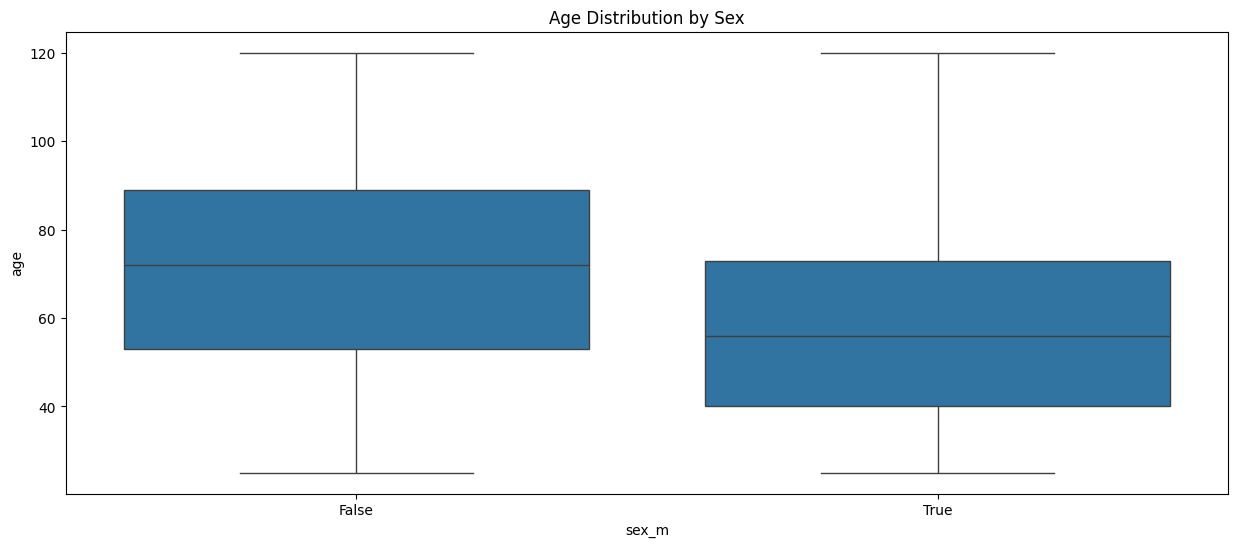

In [102]:
# Box plots for binary features
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='sex_m', y='age')
plt.title('Age Distribution by Sex')
plt.show()


In [103]:

# Basic statistics
print("\nFeature Statistics:")
print(df.describe())


Feature Statistics:
               age        weight        height        sys_bp      num_meds  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      64.63570    214.725500     67.237100    126.482400      4.590500   
std       23.19368     35.624989      3.897127     14.279162      5.512372   
min       25.00000     97.000000     53.000000     67.000000      0.000000   
25%       46.00000    190.000000     64.000000    117.000000      0.000000   
50%       64.00000    214.000000     67.000000    126.000000      3.000000   
75%       82.00000    238.000000     70.000000    136.000000      7.000000   
max      120.00000    366.000000     82.000000    180.000000     53.000000   

       occup_danger   ls_danger  drinks_aweek  major_surgery_num   cholesterol  
count  10000.000000  10000.0000  10000.000000       10000.000000  10000.000000  
mean       1.996800      2.0056      9.983400           4.170900    199.736100  
std        0.819425      0.8166  

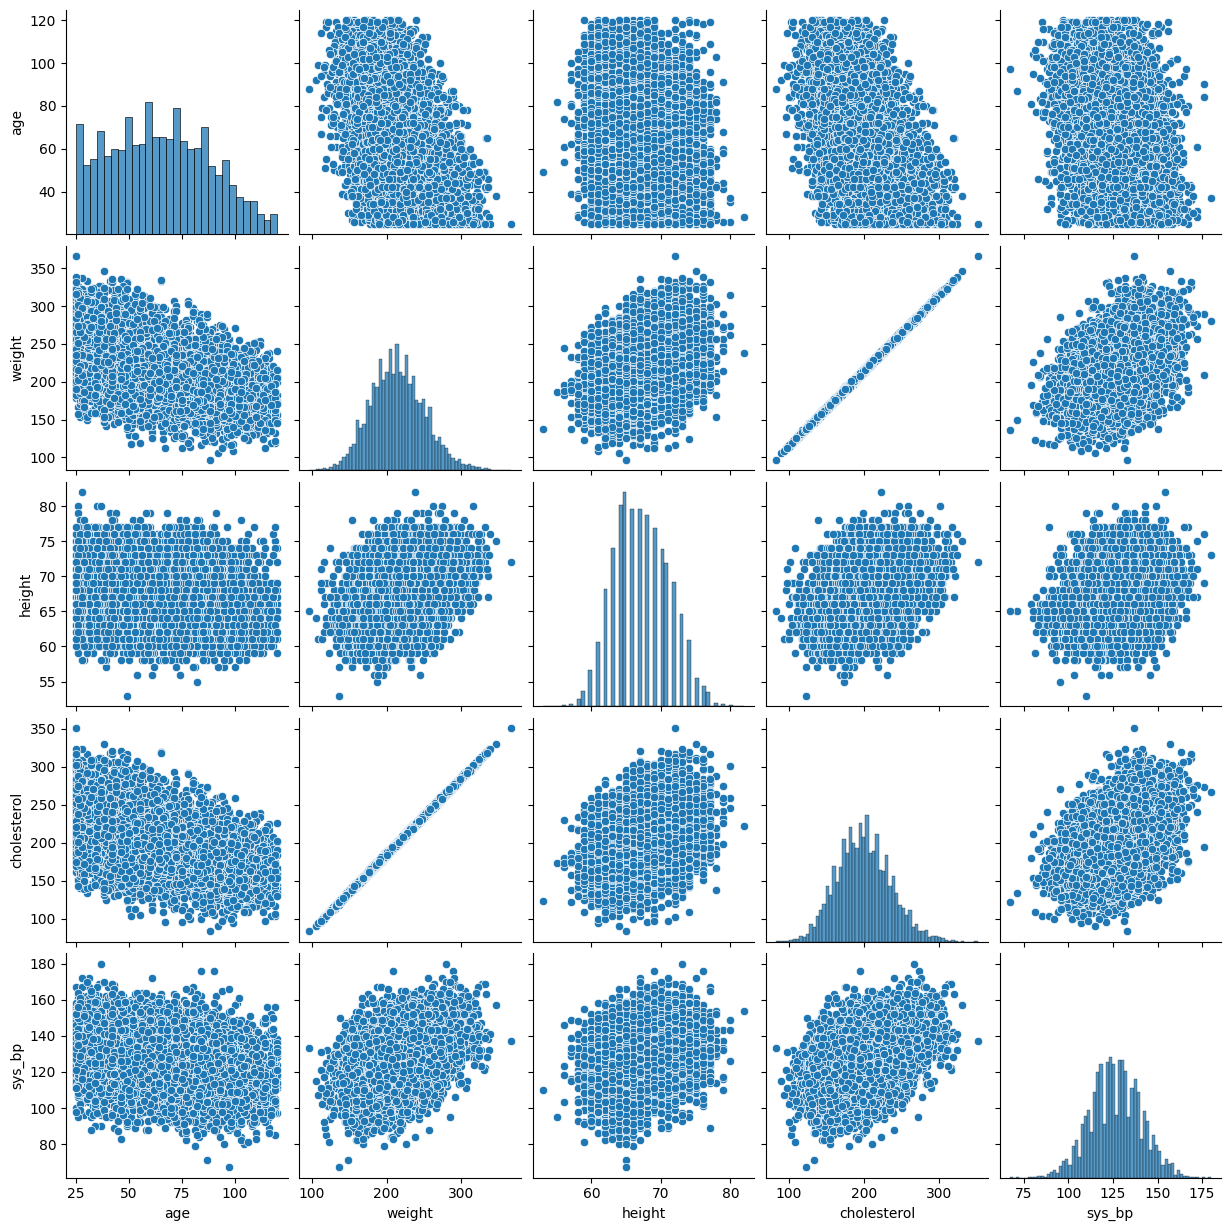

In [104]:
#Brian Risk used an interesting and visually appealing scatterplot matrix
# Pair plot
sns.pairplot(numeric_df[['age', 'weight', 'height', 'cholesterol', 'sys_bp']])
plt.show()

#source: https://www.kaggle.com/code/devraai/factors-influencing-age-of-death-analysis?scriptVersionId=219427630&cellId=10

In [105]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

X = df.drop('age', axis=1)
y = df['age']
#Age is dropped because that is the target variable attempting to be predicted

# Do train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Source: Dr. Bent

In [106]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
      print(f"{feature}: {coef:.4f}")

    return model, y_pred

    #Source: Dr. Bent

In [107]:
# Fit models
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")
ridge_model, ridge_pred = evaluate_model(Ridge(alpha=1.0), X_train_scaled, X_test_scaled, y_train, y_test, "Ridge Regression")
lasso_model, lasso_pred = evaluate_model(Lasso(alpha=0.1), X_train_scaled, X_test_scaled, y_train, y_test, "Lasso Regression")


Linear Regression:
MSE: 192.96
R2 Score: 0.65
weight: -10.2843
height: -0.6247
sys_bp: -0.9977
num_meds: -4.1096
occup_danger: -0.6681
ls_danger: -0.4130
drinks_aweek: -4.2936
major_surgery_num: -2.4260
cholesterol: 4.7195
sex_m: -2.0739
smoker_y: -1.6482
nic_other_y: -0.3691
cannabis_y: -0.1569
opioids_y: -2.3238
other_drugs_y: -1.5329
addiction_y: -7.5449
diabetes_y: -1.3155
hds_y: -4.9717
asthma_y: -0.2942
immune_defic_y: -3.8389
family_cancer_y: -2.1779
family_heart_disease_y: -1.3695
family_cholesterol_y: -0.4299

Ridge Regression:
MSE: 192.93
R2 Score: 0.65
weight: -8.5864
height: -0.6260
sys_bp: -0.9976
num_meds: -4.1095
occup_danger: -0.6682
ls_danger: -0.4130
drinks_aweek: -4.2940
major_surgery_num: -2.4259
cholesterol: 3.0229
sex_m: -2.0742
smoker_y: -1.6486
nic_other_y: -0.3698
cannabis_y: -0.1572
opioids_y: -2.3236
other_drugs_y: -1.5329
addiction_y: -7.5442
diabetes_y: -1.3150
hds_y: -4.9721
asthma_y: -0.2949
immune_defic_y: -3.8383
family_cancer_y: -2.1777
family_heart_d

<Figure size 1200x600 with 0 Axes>

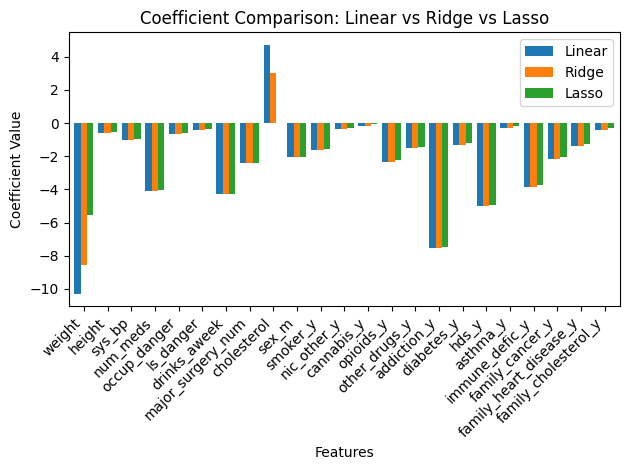

In [108]:
# Coefficient Comparison Plot
def plot_coefficients(lr_model, ridge_model, lasso_model):
    coef_df = pd.DataFrame({
        'Linear': lr_model.coef_,
        'Ridge': ridge_model.coef_,
        'Lasso': lasso_model.coef_
    }, index=X.columns)

    plt.figure(figsize=(12, 6))
    coef_df.plot(kind='bar', width=0.8)
    plt.title('Coefficient Comparison: Linear vs Ridge vs Lasso')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.legend(loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_coefficients(lr_model, ridge_model, lasso_model)

# Regression for Interpretability

* Linear Regression: The coefficients directly show the impact of each feature on the target variable
* Ridge Regression: Similar to linear regression, but with regularization to handle multicollinearity
* Lasso Regression: Performs feature selection by setting some coefficients to zero


#Correlation Coefficients from Exploratory Data Analysis:

The correlation coefficients are showing a relationship with age.

Perfect Correlation:
Weight and cholestrol have a perfect positive correlation

Age demonstrates strong negative correlations with:
Weight (r = -0.48) (i.e. as age increases, weight tends to decrease, so there is a moderate negative correlation between age and wight r =-0.48)
Cholesterol (r = -0.48)
Drinks per week (r = -0.44)

Moderate Correlations:
Weight and systolic blood pressure (r = 0.42)
Weight and height (r = 0.41)
Height and cholesterol (r = 0.40)
Height and systolic blood pressure (r = 0.34)

No Correlations:
Height and number of medications (r = -0.01)
Weight and occupation danger (r = 0.00)
Systolic blood pressure and major surgery (r = 0.00)
Several lifestyle danger indicators (ls_danger) show weak correlations with most health metrics

The number of medications and major surgery show a moderate-strong positive correlation (r = 0.58)

Generated with Claude Sonnet 3.5 02/04/2025 at 3:22 pm

#Testing Assumptions

#Testing Linearity

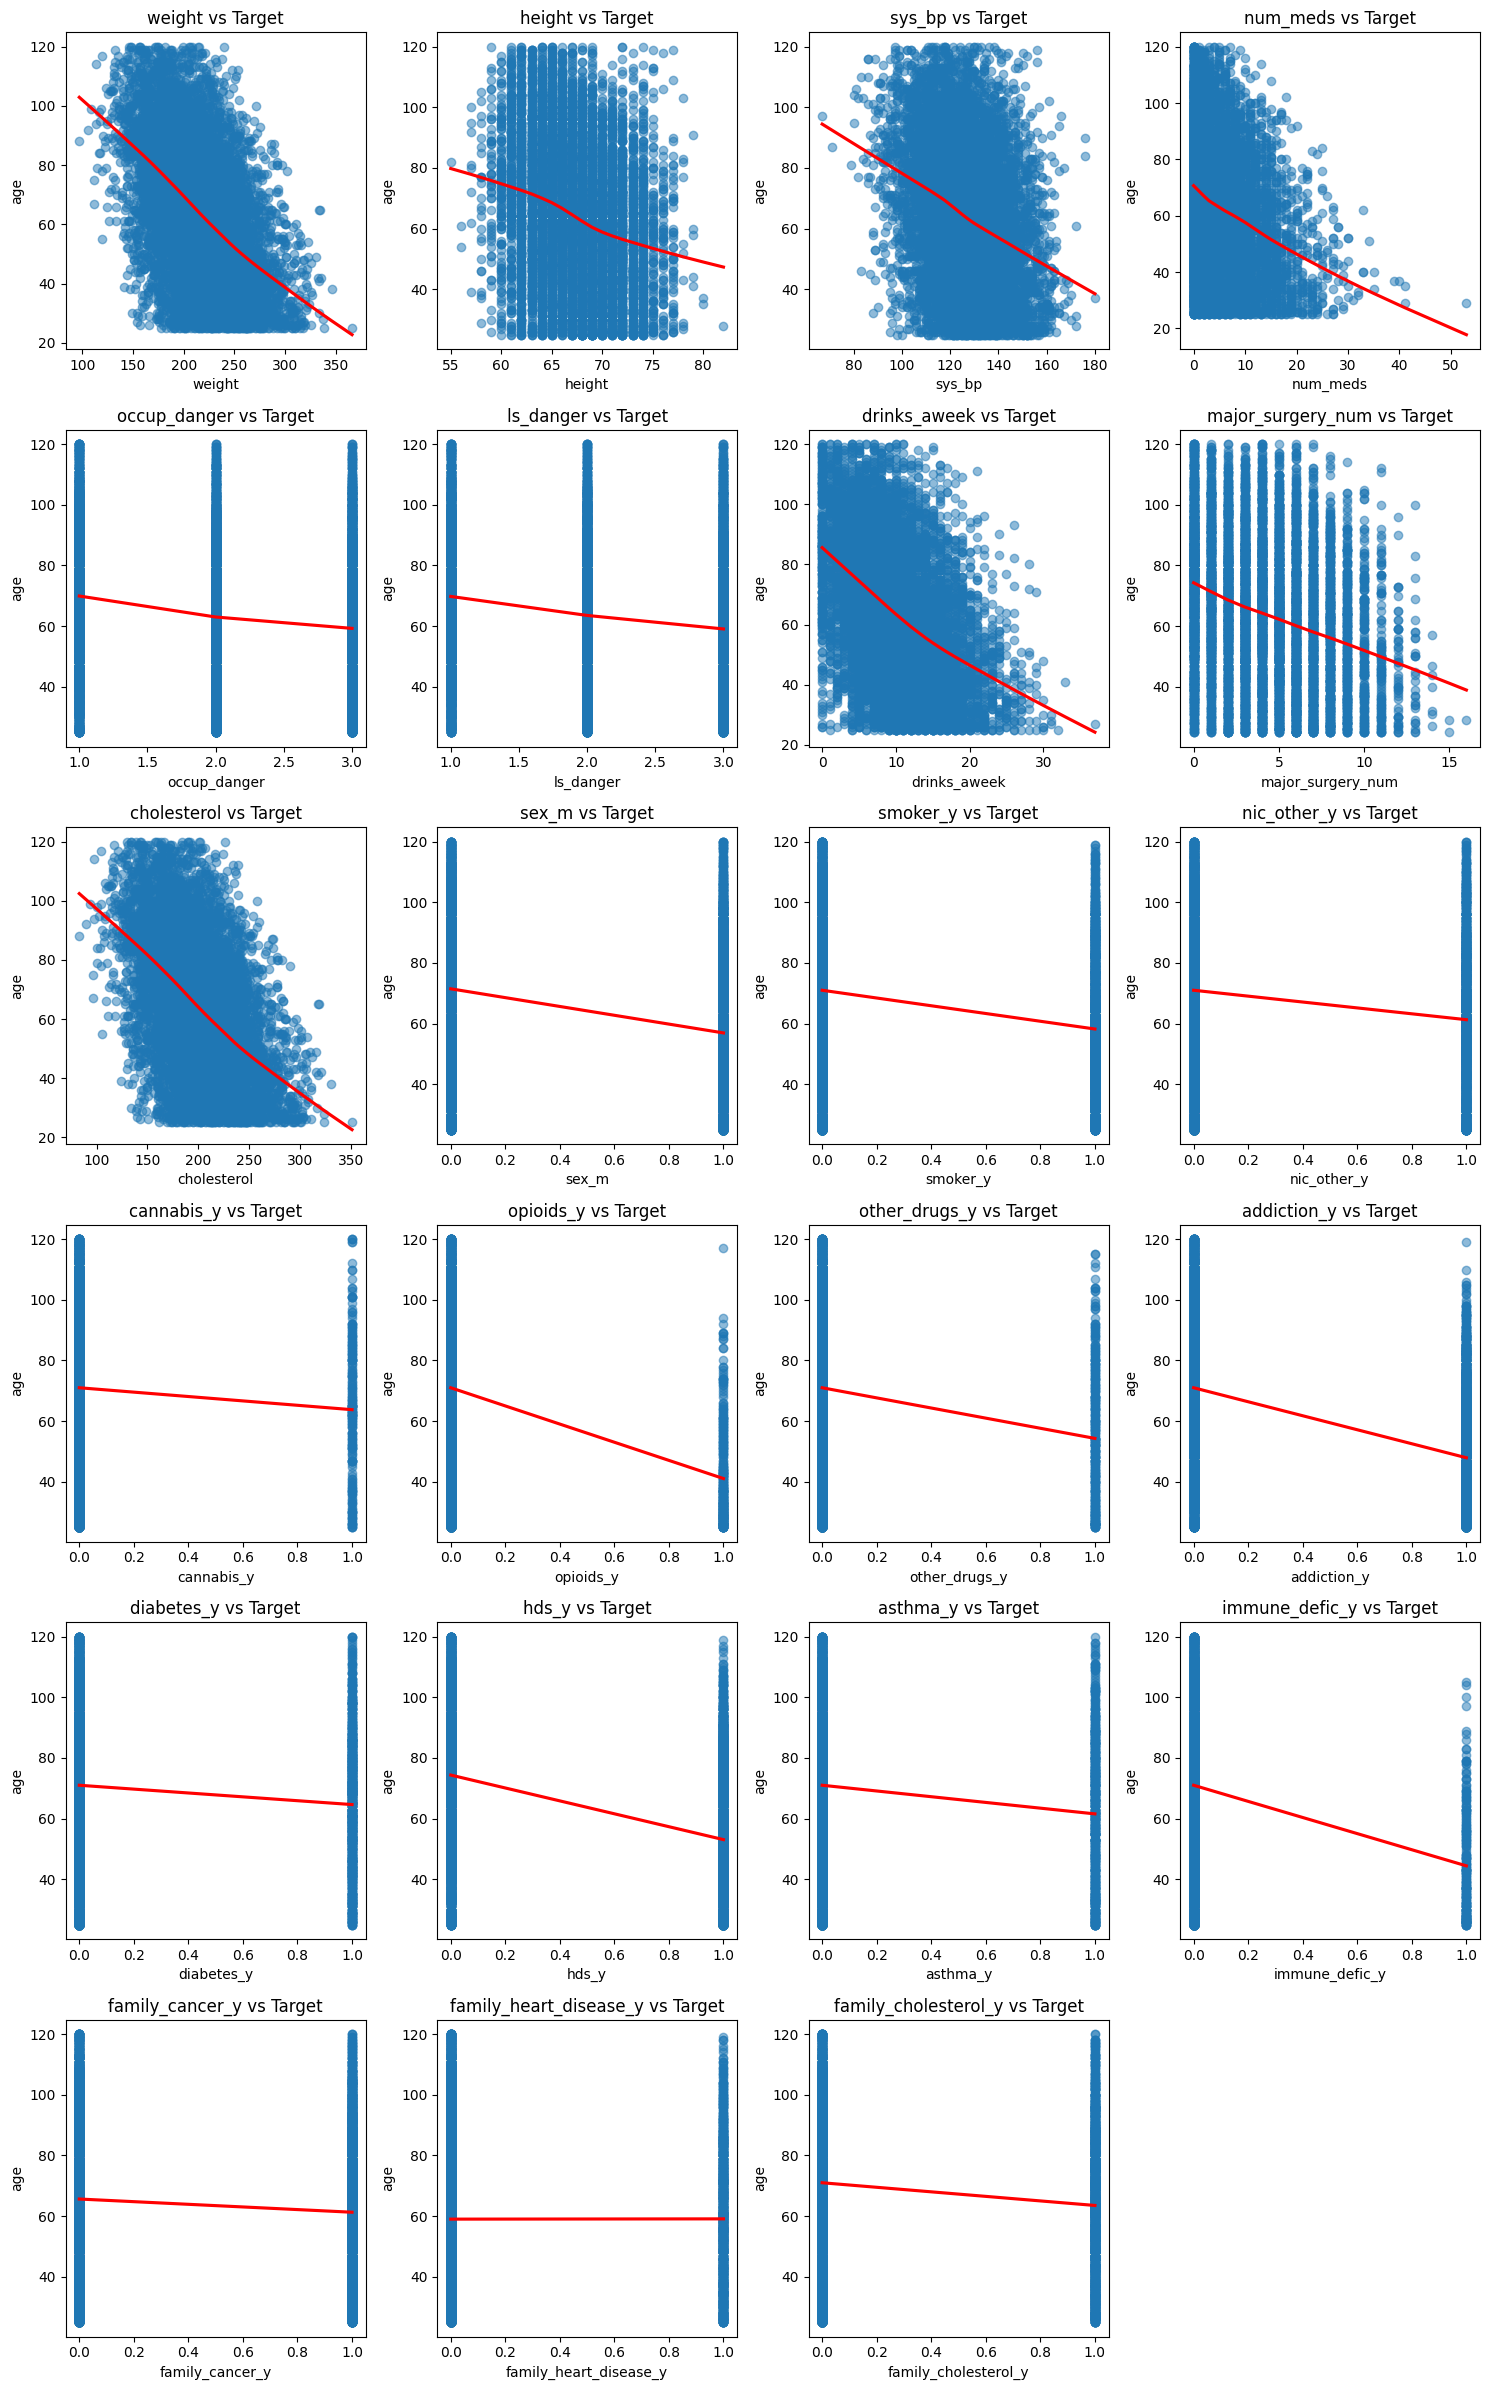

In [109]:
#Scaterplots
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate needed grid dimensions
n_features = len(X_train.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

# Create subplots
plt.figure(figsize=(15, 4*n_rows))
for i, col in enumerate(X_train.columns):
    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(X_train[col], y_train, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('Target')
    # Add lowess smoothing line to check for non-linear patterns
    sns.regplot(x=X_train[col], y=y_train, lowess=True, scatter=False, color='red')
    plt.title(f'{col} vs Target')
plt.tight_layout()
plt.show()

#Source: Claude Sonnet 3.5 02/04/2025 7:52 pm

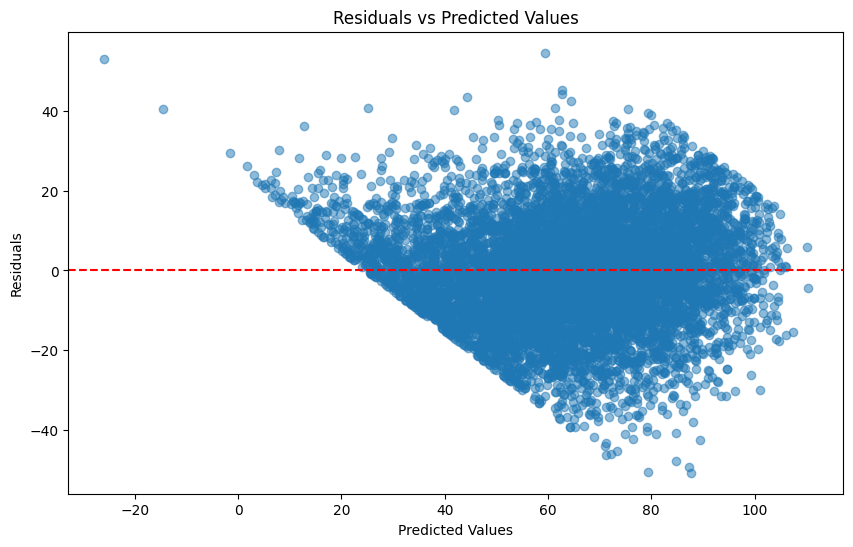

In [113]:
# Fit linear model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
residuals = y_train - y_pred

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()
#Source: Dr. Bent

This residual plot appears to be in a funnel shape - not linear.

In [114]:
# Import necessary libraries
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset

# Since your data is already scaled (X_train_scaled), we'll use that
# Make sure we're working with numpy arrays
X_train_array = np.asarray(X_train_scaled)
y_train_array = np.asarray(y_train)

# Add constant term
X_train_const = sm.add_constant(X_train_array)

# Fit the OLS model
model = sm.OLS(y_train_array, X_train_const).fit()

# Perform RESET test
reset_test = linear_reset(model, power=2)

# Access the statistics correctly
print("\nRamsey RESET test:")
print(f"F-statistic: {reset_test.statistic:.4f}")
print(f"p-value: {reset_test.pvalue:.4f}")

# Print interpretation
alpha = 0.05
print("\nInterpretation:")
if reset_test.pvalue < alpha:
    print(f"Reject H0 at {alpha} significance level.")
    print("There is evidence of functional form misspecification.")
else:
    print(f"Fail to reject H0 at {alpha} significance level.")
    print("No significant evidence of functional form misspecification.")
    #Source: Generated with Claude Sonnet 3.5 02/04/2025 8:04 pm


Ramsey RESET test:
F-statistic: 374.5275
p-value: 0.0000

Interpretation:
Reject H0 at 0.05 significance level.
There is evidence of functional form misspecification.


The assumption of linearity is violated. Therefore, it is necessary to take remediation steps. For this, the varibales will be transformed. Claude recommended that I transform the variables before doing a test_train_split to avoid data leakage, however, I refrained from doing that because I want to show all of my work. Claude recommended a random forest model to use a regression model without the assumption of linearity. While the results are not perefectly linear, they are good enough.

In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Random Forest (handles non-linearity well)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
print("Random Forest R2:", r2_score(y_test, rf_pred))

# Support Vector Regression with non-linear kernel
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)
svr_pred = svr_model.predict(X_test_scaled)
print("SVR R2:", r2_score(y_test, svr_pred))
#Generated with Claude Sonnet 3.5 02/05/2025 at 4:07 pm

Random Forest R2: 0.6084786675101739
SVR R2: 0.6380990403030169


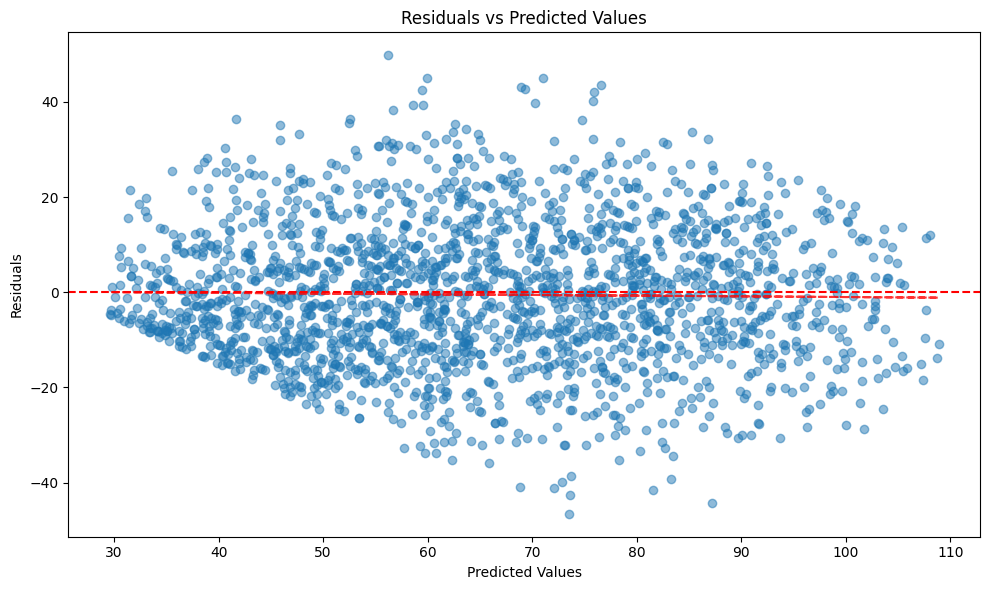

In [116]:
# Get predictions and residuals
predictions = rf_model.predict(X_test_scaled)
residuals = y_test - predictions

# Create residual plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

# Add a trend line to check for patterns
z = np.polyfit(predictions, residuals, 1)
p = np.poly1d(z)
plt.plot(predictions, p(predictions), "r--", alpha=0.8)

plt.tight_layout()
plt.show()
#Generated with Claude Sonnet 3.5 02/05/2025 4:08 pm

#Independence of Observations

In [117]:

#Durbin-Watson Test

from statsmodels.stats.stattools import durbin_watson

# After fitting your model
residuals = model.resid
dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_statistic:.4f}")
#Source: Generated with Claude Sonnet 3.5 02/04/2025 8:05 pm

Durbin-Watson statistic: 2.0286


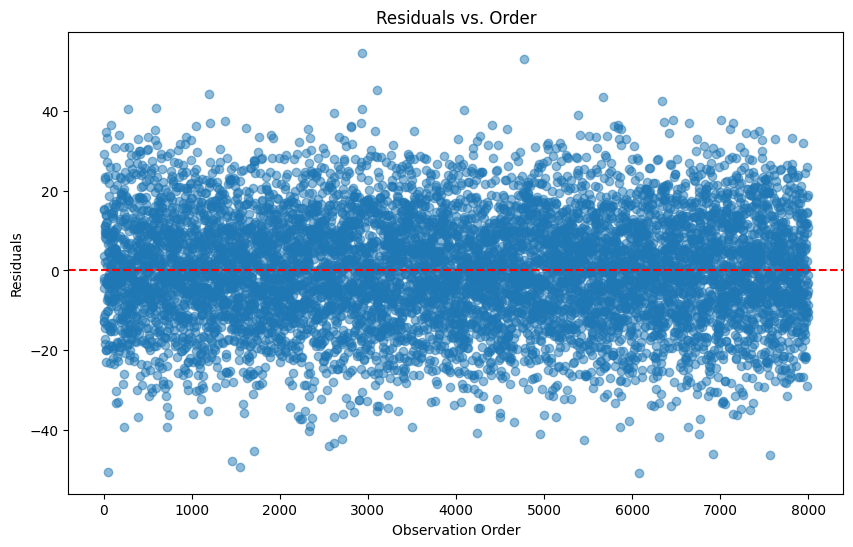

In [118]:
#Residuals vs Observation Order
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Observation Order')
plt.ylabel('Residuals')
plt.title('Residuals vs. Order')
plt.show()

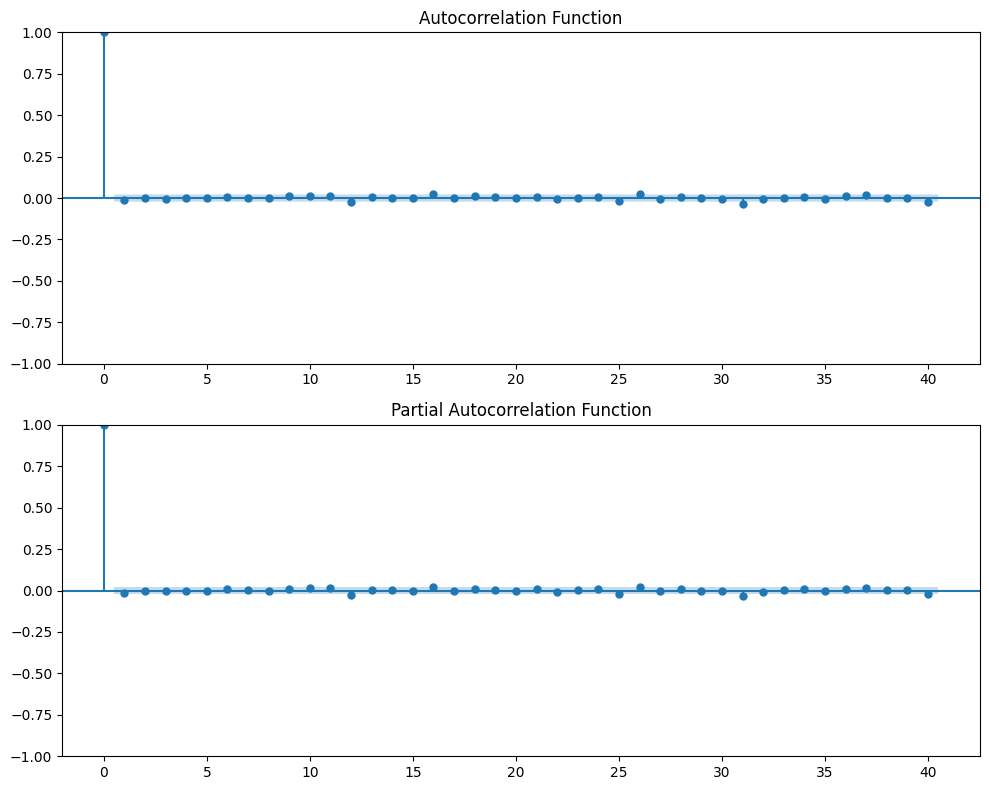

In [119]:
#ACF and #PACFT
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ACF Plot
plot_acf(residuals, lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function')

# PACF Plot
plot_pacf(residuals, lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [120]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# Perform Breusch-Godfrey test
bg_test = acorr_breusch_godfrey(model, nlags=5)

print("\nBreusch-Godfrey Test Results:")
print(f"LM test statistic: {bg_test[0]:.4f}")
print(f"p-value: {bg_test[1]:.4f}")
print(f"F-statistic: {bg_test[2]:.4f}")
print(f"F-test p-value: {bg_test[3]:.4f}")

# If p-value < 0.05, reject null hypothesis of no autocorrelation
#Source: Generated with Claude Sonnet 3.5 02/04/2025 8:12 pm


Breusch-Godfrey Test Results:
LM test statistic: 1.8082
p-value: 0.8750
F-statistic: 0.3604
F-test p-value: 0.8758


The assumption of the independence of observations has been met. The p value is above 0.05, and the plots appear to be scattered randomly.

#Testing Homoscedasticity

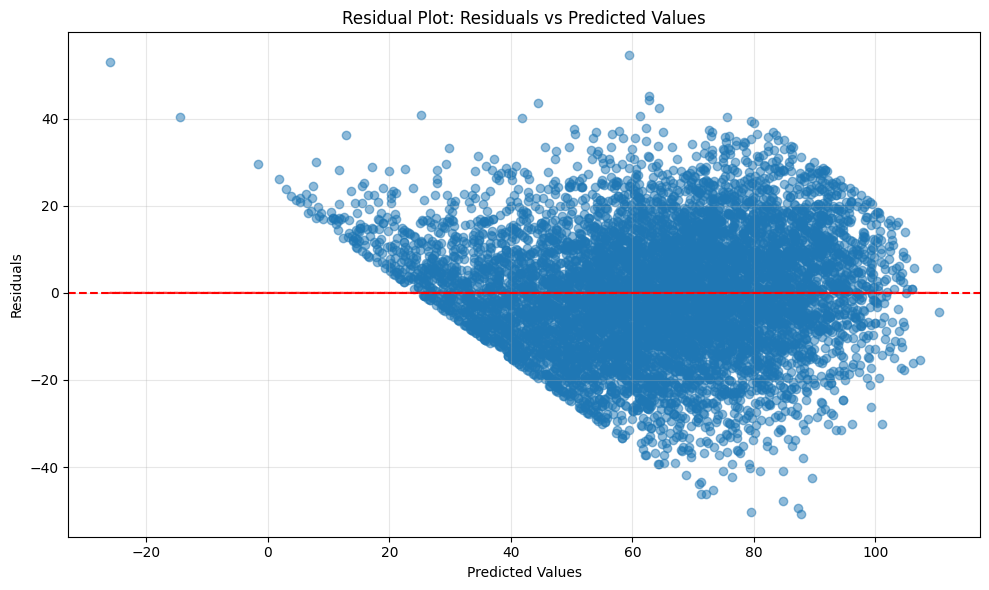

In [121]:
# Residuals vs Predicted Plot
#Fit the model and get predictions
X_train_array = np.asarray(X_train_scaled)
y_train_array = np.asarray(y_train)
X_train_const = sm.add_constant(X_train_array)
model = sm.OLS(y_train_array, X_train_const).fit()
predictions = model.predict(X_train_const)

# Calculate residuals
residuals = model.resid

# Create the residual plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot: Residuals vs Predicted Values')

# Add a trend line to help spot patterns
z = np.polyfit(predictions, residuals, 1)
p = np.poly1d(z)
plt.plot(predictions, p(predictions), "r--", alpha=0.8)

# Add grid for better readability
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
#Generated with Claude Sonnet 3.5 02/04/2025 8:16 pm

In [122]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Perform Breusch-Pagan test using the existing model
bp_test = het_breuschpagan(model.resid, model.model.exog)

# Print results
print("\nBreusch-Pagan test for heteroskedasticity")
print("------------------------------------------")
print(f"Lagrange Multiplier statistic: {bp_test[0]:.4f}")
print(f"p-value: {bp_test[1]:.4f}")
print(f"F-statistic: {bp_test[2]:.4f}")
print(f"F-test p-value: {bp_test[3]:.4f}")

# Print interpretation
alpha = 0.05
print("\nInterpretation:")
if bp_test[1] < alpha:
    print(f"Reject H0 at {alpha} significance level.")
    print("There is significant evidence of heteroskedasticity (non-constant variance).")
else:
    print(f"Fail to reject H0 at {alpha} significance level.")
    print("No significant evidence of heteroskedasticity (variance appears constant).")
    #Generated with Claude Sonnet 3.5 02/04/2025 8:18 pm


Breusch-Pagan test for heteroskedasticity
------------------------------------------
Lagrange Multiplier statistic: 52.9446
p-value: 0.0004
F-statistic: 2.3103
F-test p-value: 0.0004

Interpretation:
Reject H0 at 0.05 significance level.
There is significant evidence of heteroskedasticity (non-constant variance).


In [123]:
#White Test
from statsmodels.stats.diagnostic import het_white

# Perform White's test using the existing model
white_test = het_white(model.resid, model.model.exog)

print("\nWhite's test for heteroskedasticity")
print("------------------------------------")
print(f"LM statistic: {white_test[0]:.4f}")
print(f"p-value: {white_test[1]:.4f}")
print(f"F statistic: {white_test[2]:.4f}")
print(f"F p-value: {white_test[3]:.4f}")

if white_test[1] < 0.05:
    print("\nReject H0: There is significant evidence of heteroskedasticity")
else:
    print("\nFail to reject H0: No significant evidence of heteroskedasticity")
    #Generated with Claude Sonnet 3.5 02/04/2025 8:18 pm



White's test for heteroskedasticity
------------------------------------
LM statistic: 363.1126
p-value: 0.0012
F statistic: 1.2869
F p-value: 0.0010

Reject H0: There is significant evidence of heteroskedasticity


In [124]:
# Goldfeld-Quandt
from statsmodels.stats.diagnostic import het_goldfeldquandt

# Perform Goldfeld-Quandt test using the existing model
gq_test = het_goldfeldquandt(model.resid, model.model.exog)

print("\nGoldfeld-Quandt test for heteroskedasticity")
print("-------------------------------------------")
print(f"F statistic: {gq_test[0]:.4f}")
print(f"p-value: {gq_test[1]:.4f}")

if gq_test[1] < 0.05:
    print("\nReject H0: There is significant evidence of heteroskedasticity")
else:
    print("\nFail to reject H0: No significant evidence of heteroskedasticity")
    ##Generated with Claude Sonnet 3.5 02/04/2025 8:21 pm


Goldfeld-Quandt test for heteroskedasticity
-------------------------------------------
F statistic: 0.9880
p-value: 0.6484

Fail to reject H0: No significant evidence of heteroskedasticity


The assumption of Homoscedasticity has not been met.

In [126]:
import statsmodels.api as sm

# Assuming your model is already fit
# Print results with robust standard errors
print(model.get_robustcov_results(cov_type='HC3').summary())
# Using HC3 (recommended) robust standard errors

# Print results with robust standard errors
print(model.get_robustcov_results(cov_type='HC3').summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     675.8
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:41:53   Log-Likelihood:                -32332.
No. Observations:                8000   AIC:                         6.471e+04
Df Residuals:                    7976   BIC:                         6.488e+04
Df Model:                          23                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.5556      0.154    418.061      0.0

This model uses HC3 robust standard errors to correct for heteroscedasticity. The coefficient estimates are still valid, however, the standard errors have been changed to be more reliable.
Generated with Claude Sonnet 3.5 02/05/2025 5:43 pm

#Normality of Residuals

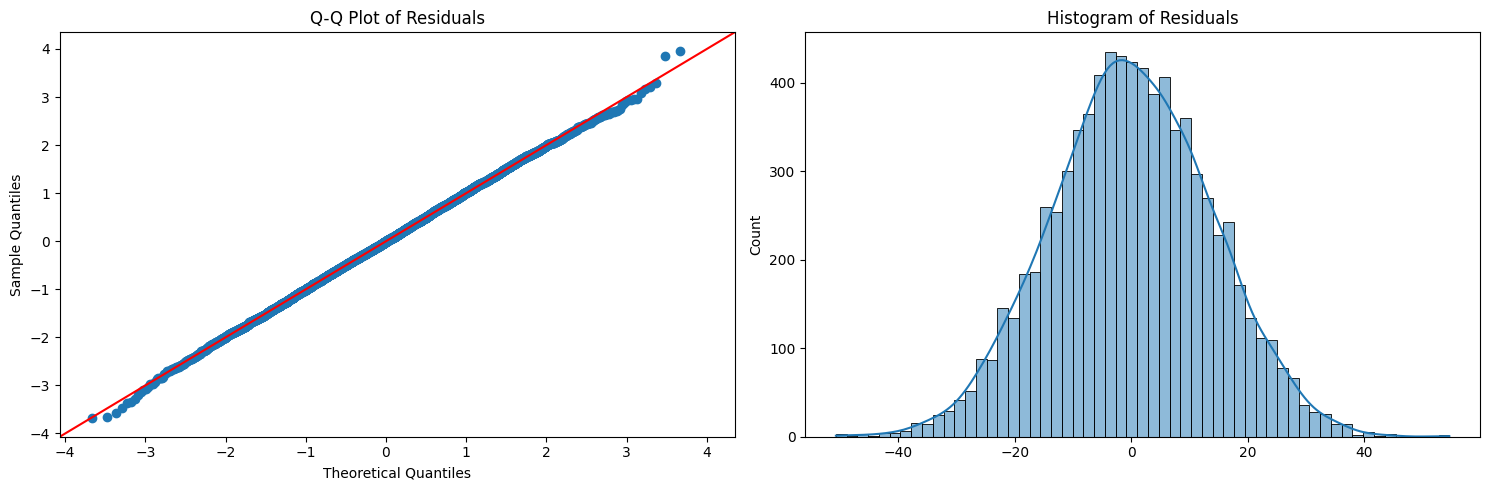


Normality Tests of Residuals
----------------------------------------

Shapiro-Wilk test:
Statistic: 0.9998
p-value: 0.6532

Kolmogorov-Smirnov test:
Statistic: 0.0050
p-value: 0.9882

Anderson-Darling test:
Statistic: 0.2501
Critical values:
15.0%: 0.576
10.0%: 0.656
5.0%: 0.787
2.5%: 0.918
1.0%: 1.091

Jarque-Bera test:
Statistic: 1.4809
p-value: 0.4769

Interpretation:
Most tests suggest the residuals are approximately normally distributed.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

# Getting residuals from existing model
residuals = model.resid

# 1. Create Q-Q plot and histogram in one figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Q-Q plot
sm.graphics.qqplot(residuals, line='45', fit=True, ax=ax1)
ax1.set_title('Q-Q Plot of Residuals')

# Histogram
sns.histplot(residuals, kde=True, ax=ax2)
ax2.set_title('Histogram of Residuals')
plt.tight_layout()
plt.show()

# 2. Perform normality tests
print("\nNormality Tests of Residuals")
print("-" * 40)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print("\nShapiro-Wilk test:")
print(f"Statistic: {shapiro_stat:.4f}")
print(f"p-value: {shapiro_p:.4f}")

# Kolmogorov-Smirnov test
ks_stat, ks_p = stats.kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
print("\nKolmogorov-Smirnov test:")
print(f"Statistic: {ks_stat:.4f}")
print(f"p-value: {ks_p:.4f}")

# Anderson-Darling test
ad_result = stats.anderson(residuals, dist='norm')
print("\nAnderson-Darling test:")
print(f"Statistic: {ad_result.statistic:.4f}")
print("Critical values:")
for i in range(len(ad_result.critical_values)):
    print(f"{ad_result.significance_level[i]}%: {ad_result.critical_values[i]}")

# Jarque-Bera test using scipy
jb_stat, jb_p = stats.jarque_bera(residuals)
print("\nJarque-Bera test:")
print(f"Statistic: {jb_stat:.4f}")
print(f"p-value: {jb_p:.4f}")

# Overall interpretation
print("\nInterpretation:")
alpha = 0.05
tests_failed = sum([shapiro_p < alpha, ks_p < alpha, jb_p < alpha])
if tests_failed >= 2:
    print("Multiple tests suggest the residuals are not normally distributed.")
else:
    print("Most tests suggest the residuals are approximately normally distributed.")

The assumption for normality of residuals has been met.

#Building a GAM

In [128]:
!pip install pygam --quiet
#Source: Dr. Bent

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 17.9 MB/s eta 0:00:00


In [129]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
from pygam import LinearGAM, s
# Initilize GAM
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9))

# Find best smoothing parameters for each spline term
gam.gridsearch(X_train_scaled, y_train)

# Fit the model
gam.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gam = gam.predict(X_test_scaled)

# Calculate MSE and R^2
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)

print(f"GAM MSE: {mse_gam:.4f}, R^2: {r2_gam:.4f}")

gam.summary()
#Source: Dr. Bent

100% (11 of 11) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


GAM MSE: 307.3792, R^2: 0.4388
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     28.3649
Link Function:                     IdentityLink Log Likelihood:                                -52990.7615
Number of Samples:                         8000 AIC:                                           106040.2529
                                                AICc:                                          106040.4766
                                                GCV:                                              301.7641
                                                Scale:                                            299.8388
                                                Pseudo R-Squared:                                    0.442
Featur

#GAM Coefficient Plot

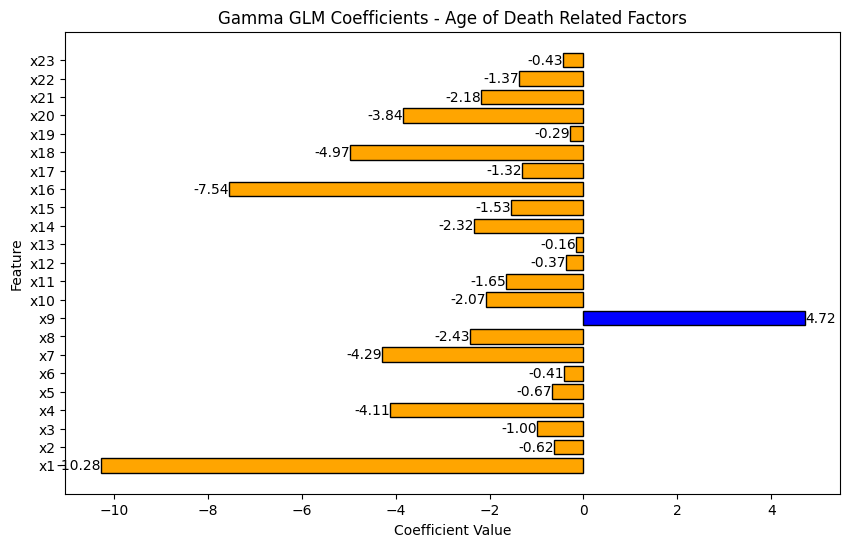

In [141]:
# The data structure looks correct, but the plotting code needs adjustment
feature_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
                'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
                'x20', 'x21', 'x22', 'x23']

# Convert the dictionary values to a list in the same order as feature_names
coef_values = [coefficients[name] for name in feature_names]

# Create colors list based on coefficient signs
colors = ['blue' if coef > 0 else 'orange' for coef in coef_values]

plt.figure(figsize=(10, 6))
bars = plt.barh(feature_names, coef_values, color=colors, edgecolor='black')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Gamma GLM Coefficients - Age of Death Related Factors')

# Add value labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             va='center', ha='left' if width > 0 else 'right')

plt.show()
#Source Dr. Bent and Claude Sonnet 3.5 02/05/2025 6:04 pm

#"Feature Effects on Age of Death"


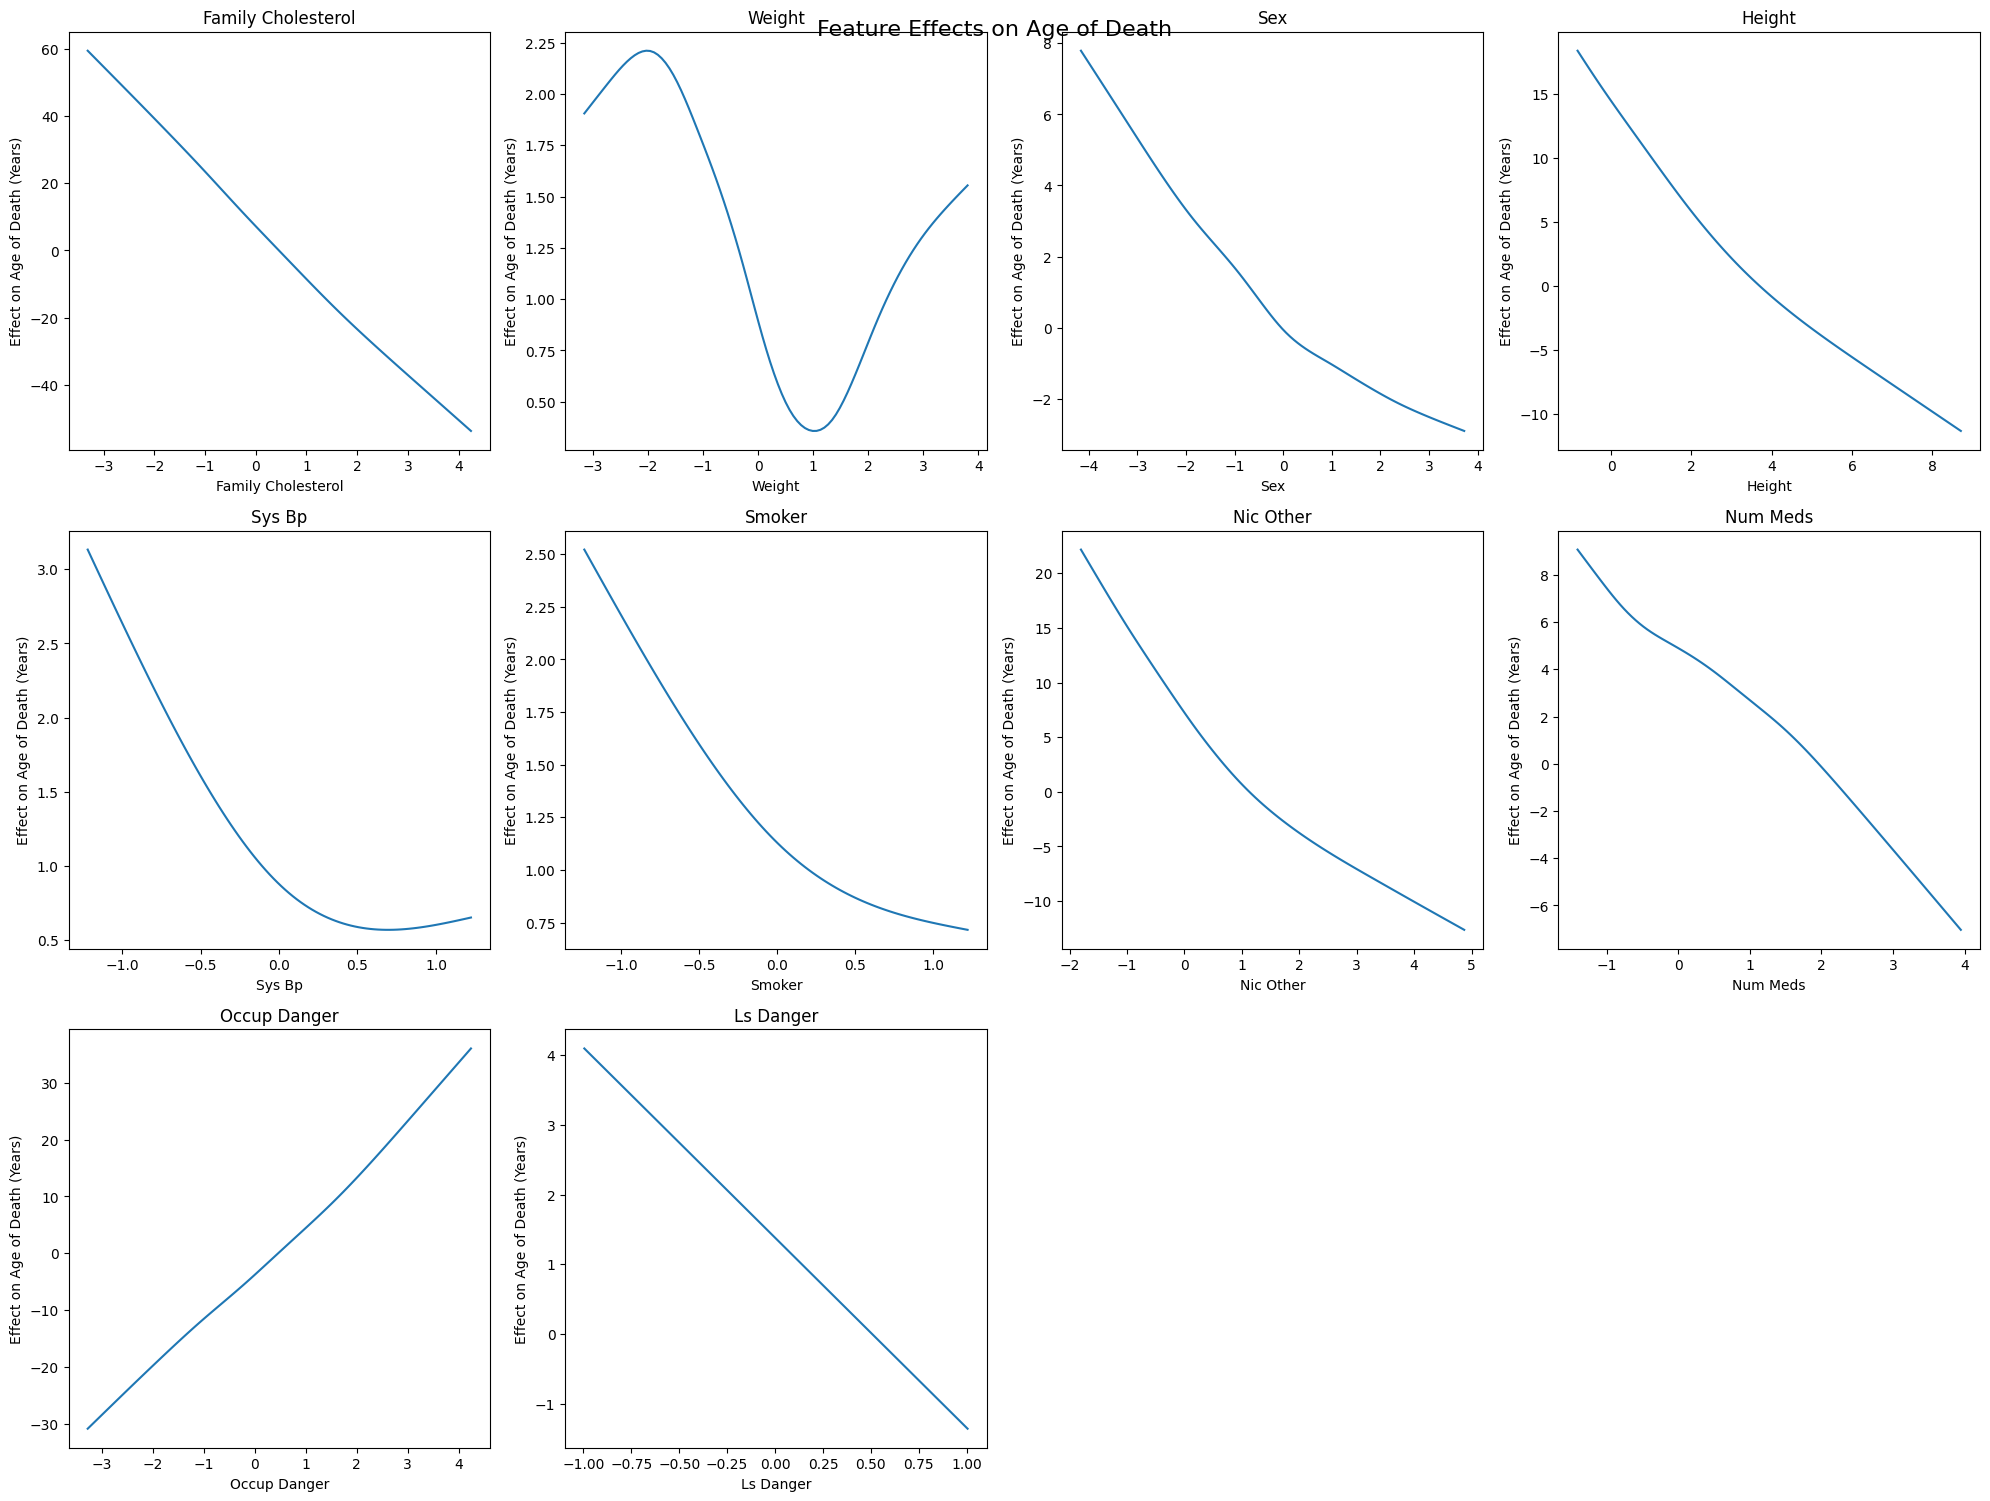

In [149]:
# Create a list of your descriptive feature names
feature_names = [
    'weight',
    'sex',
    'height',
    'sys_bp',
    'smoker',
    'nic_other',
    'num_meds',
    'occup_danger',
    'ls_danger',
    'cannabis',
    'opioids',
    'other_drugs',
    'drinks_aweek',
    'addiction',
    'major_surgery_num',
    'diabetes',
    'hds',
    'cholesterol',
    'asthma',
    'immune_defic',
    'family_cancer',
    'family_heart_disease',
    'family_cholesterol'
]

# Calculate number of rows and columns needed for subplots
n_features = len(feature_names)
n_cols = 4  # You can adjust this
n_rows = (n_features + n_cols - 1) // n_cols

# Create the visualization
plt.figure(figsize=(20, 5*n_rows))

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(n_rows, n_cols, i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))

    # Create more readable titles
    title = feature_names[i-1].replace('_', ' ').title()
    if title.endswith('_y'):
        title = title[:-2]
    if title.endswith('_m'):
        title = title[:-2] + ' (Male)'

    plt.title(title)
    plt.ylabel('Effect on Age of Death (Years)')  # Updated y-axis label for each subplot
    plt.xlabel(title)

plt.suptitle('Feature Effects on Age of Death', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
Source: https://claude.site/artifacts/f8a1d2b0-0450-456c-9b94-792abefa084d

#PDP Plot

In [260]:
non_binary_cols = [col for col in df.columns if df[col].dtype != 'bool']
print("Non-binary features:")
print(non_binary_cols)

Non-binary features:
['age', 'weight', 'height', 'sys_bp', 'num_meds', 'occup_danger', 'ls_danger', 'drinks_aweek', 'major_surgery_num', 'cholesterol']


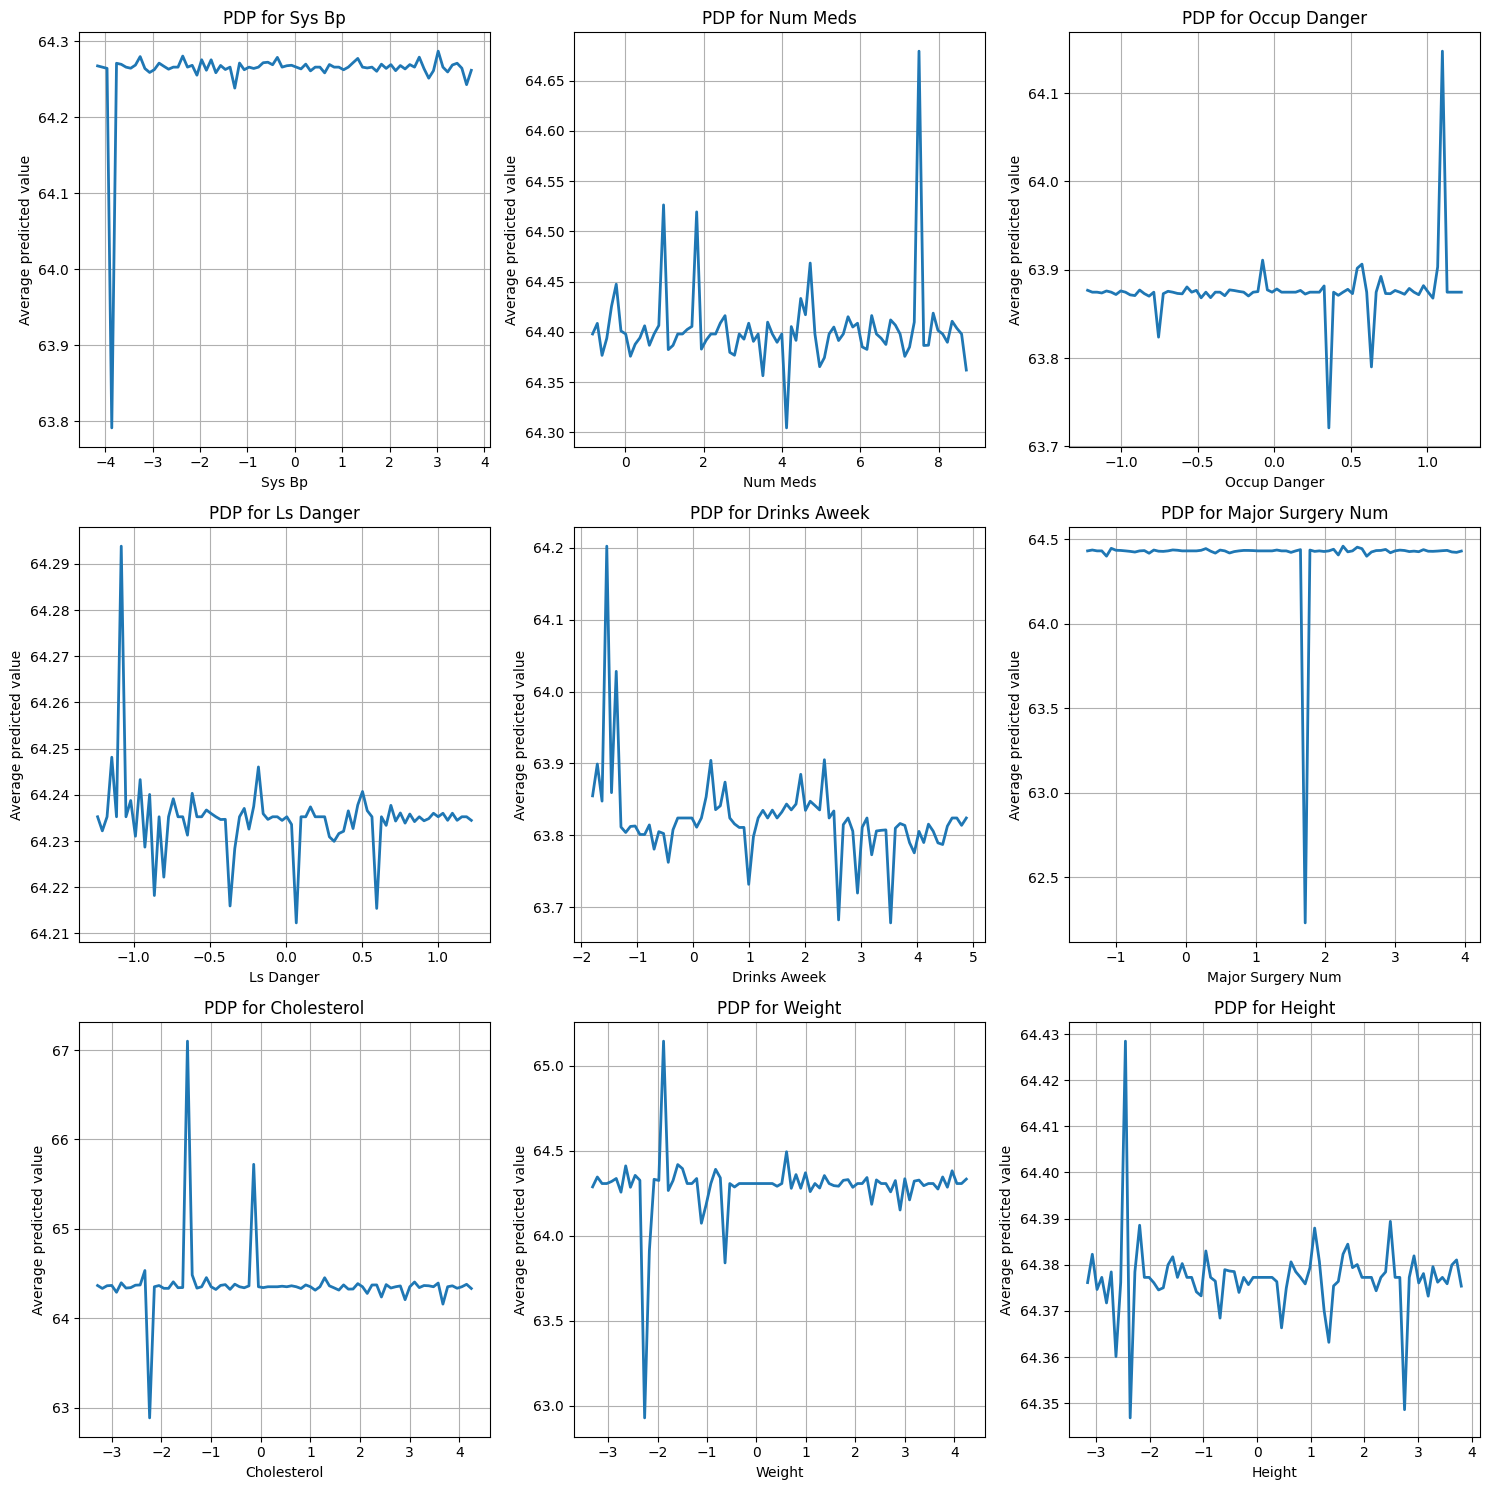

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_all_partial_dependence(X_train_df, gam, features):
    # Calculate number of rows and columns for subplot grid
    n_features = len(features)
    n_cols = 3  # We can show 3 plots per row
    n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

    plt.figure(figsize=(15, 5*n_rows))

    for idx, feature in enumerate(features):
        feature_index = X_train_df.columns.get_loc(feature)

        feature_values = np.linspace(
            np.min(X_train_df.iloc[:, feature_index]),
            np.max(X_train_df.iloc[:, feature_index]),
            num=80
        )

        average_predictions = np.zeros_like(feature_values)
        X_modified = X_train_df.copy()

        for i, value in enumerate(feature_values):
            X_modified.iloc[:, feature_index] = value
            X_modified_scaled = (X_modified - X_modified.mean()) / X_modified.std()
            predictions = gam.predict(X_modified_scaled)
            average_predictions[i] = np.mean(predictions)

        plt.subplot(n_rows, n_cols, idx + 1)
        plt.plot(feature_values, average_predictions, linewidth=2)
        plt.xlabel(feature.replace('_', ' ').title())
        plt.ylabel('Average predicted value')
        plt.title(f'PDP for {feature.replace("_", " ").title()}')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Define the features
features = ['sys_bp', 'num_meds', 'occup_danger', 'ls_danger',
           'drinks_aweek', 'major_surgery_num', 'cholesterol', 'weight', 'height']

# Call the function
plot_all_partial_dependence(X_train_df, gam, features)
#Source: Claude Sonnet 3.5 02/06/2025 12:29 AM

Most of the show non-linear relationsips, confirming that it was a good idea to use a GAM mode. Height appears to be linear. Meanwhile, drinks per week, cholesterol, and number of surgueries are non linear.

Weight had the strongest negative coefficienct in the coefficient plot, but in the pdp plot evens out a bit, suggesting that the relationship might not be as strong as the coefficient plot suggests.

Sysbp was well-captured by the linear plots but the numbers of major surgery is not well-captured in a linear relationsip, and requires something like GAM to show what is happening.

Claude Sonnet 3.5 02/06/2025 1:00 am

#ICE Plot

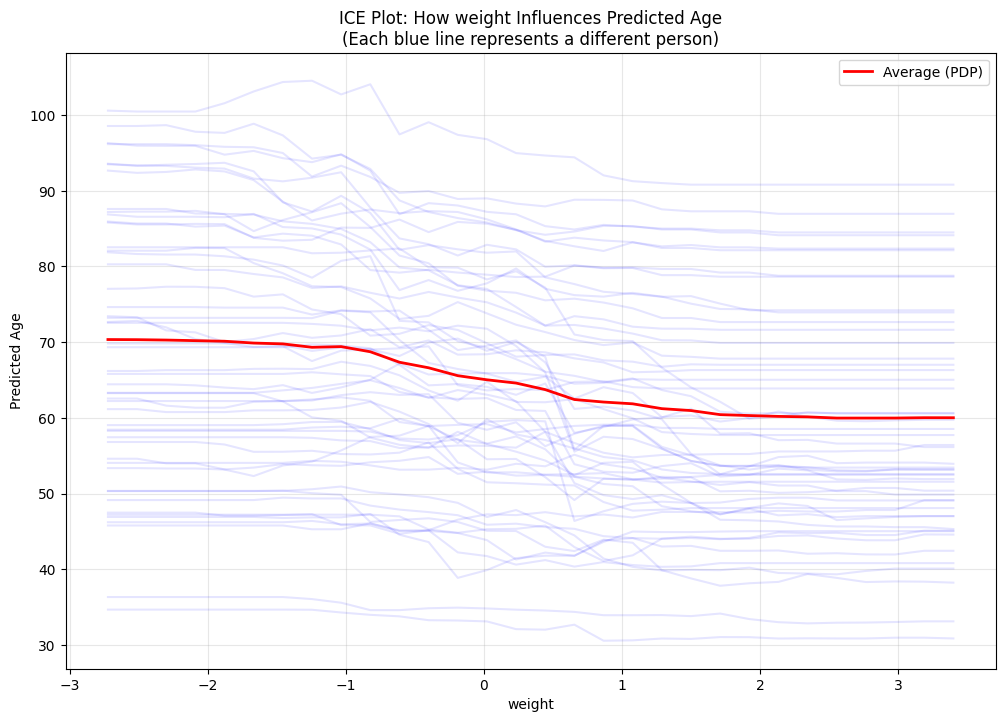

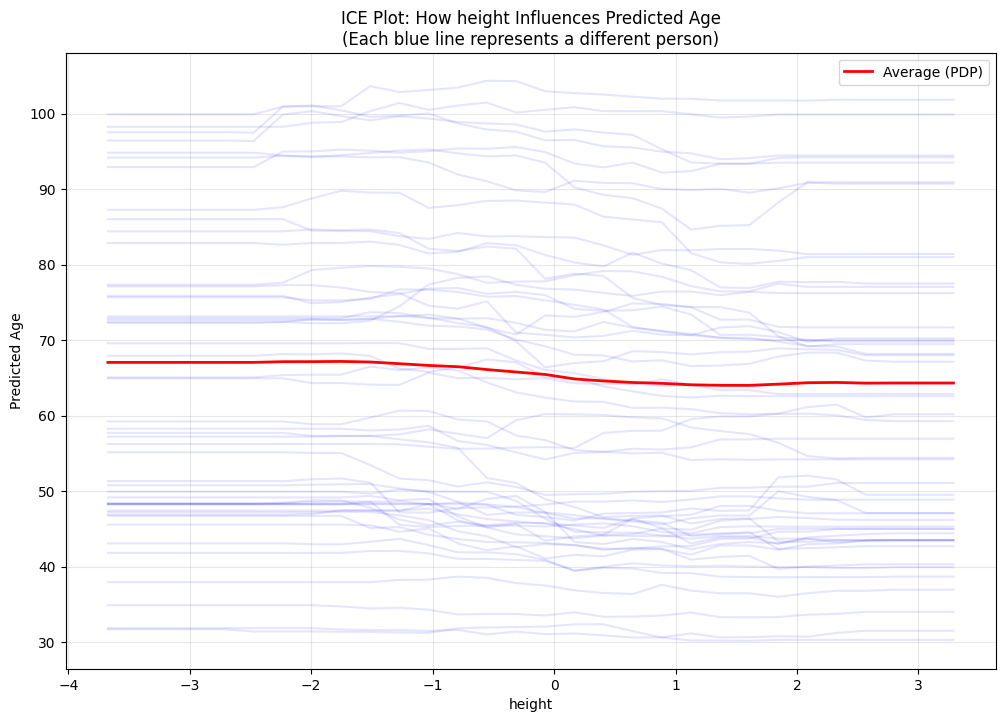

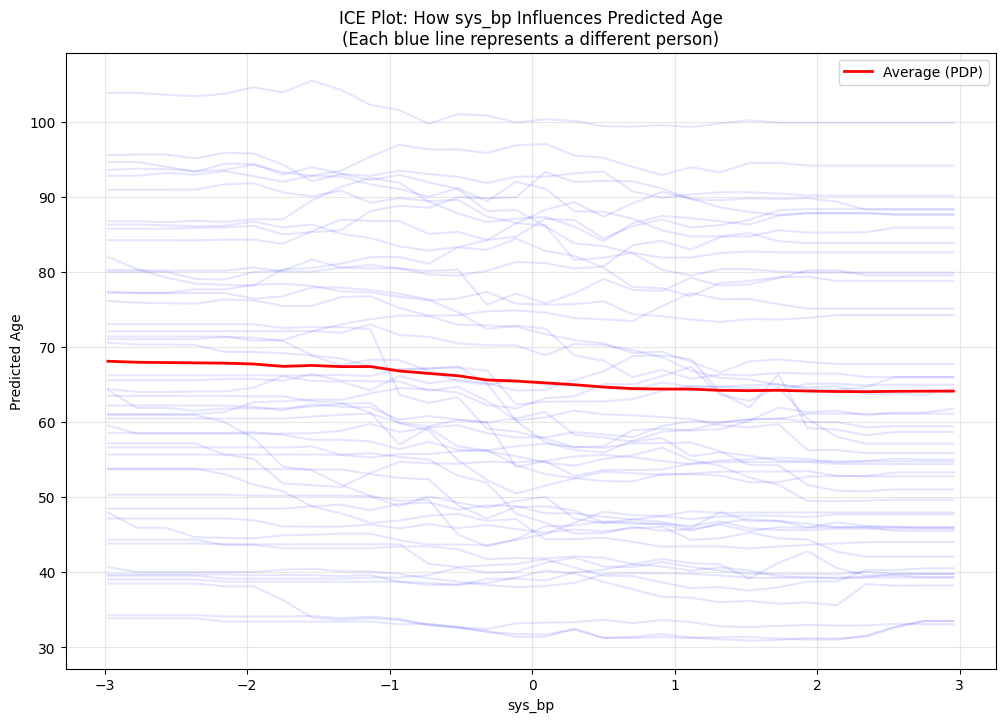

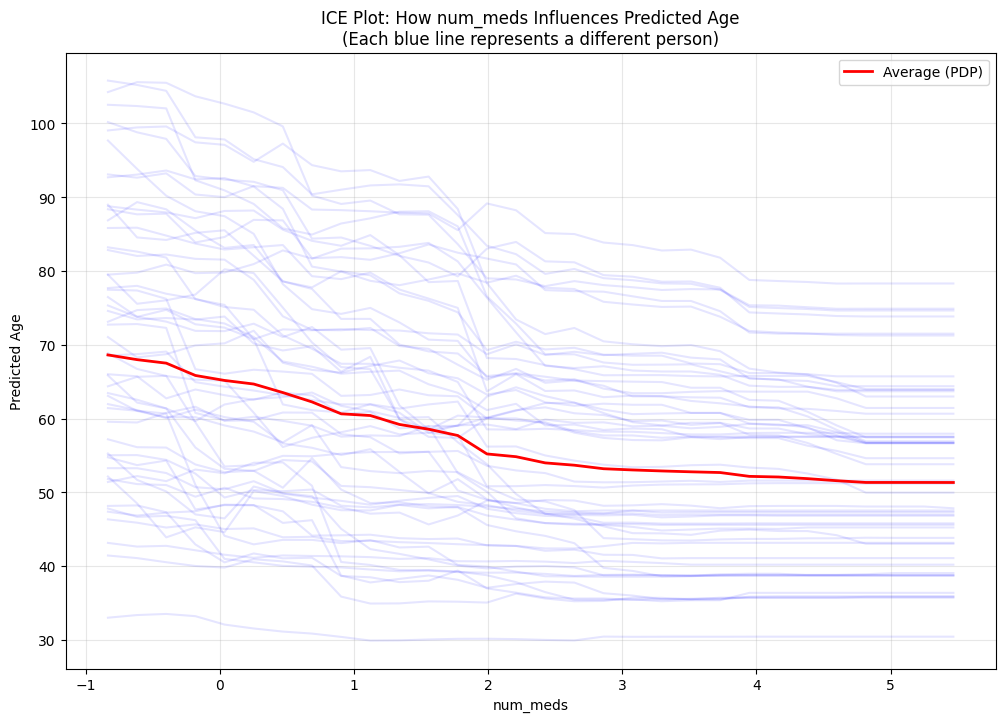

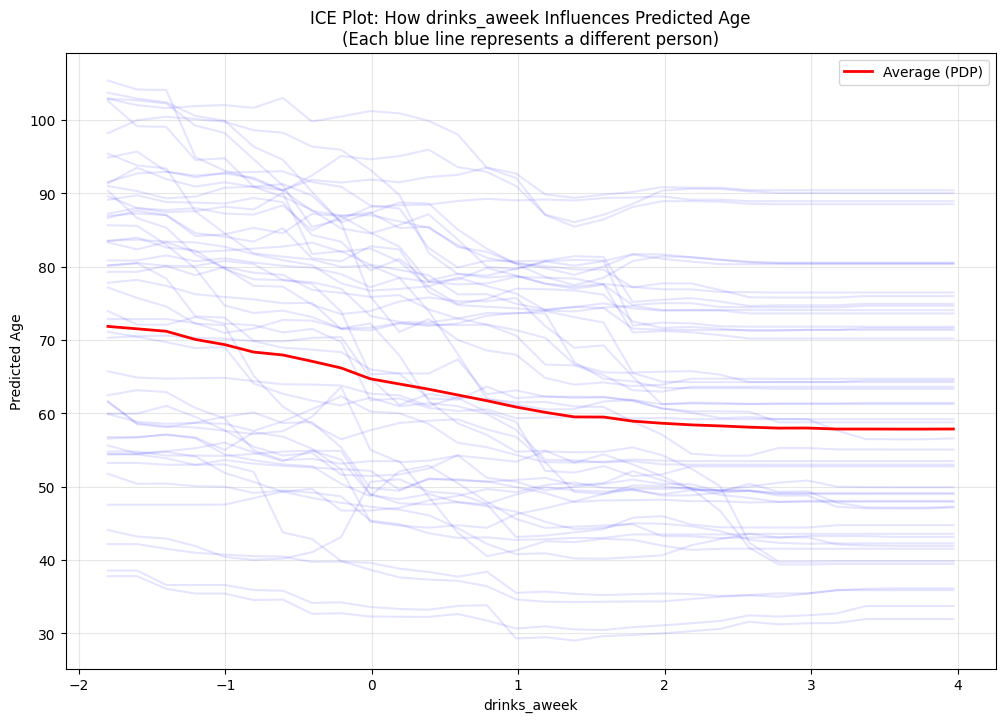

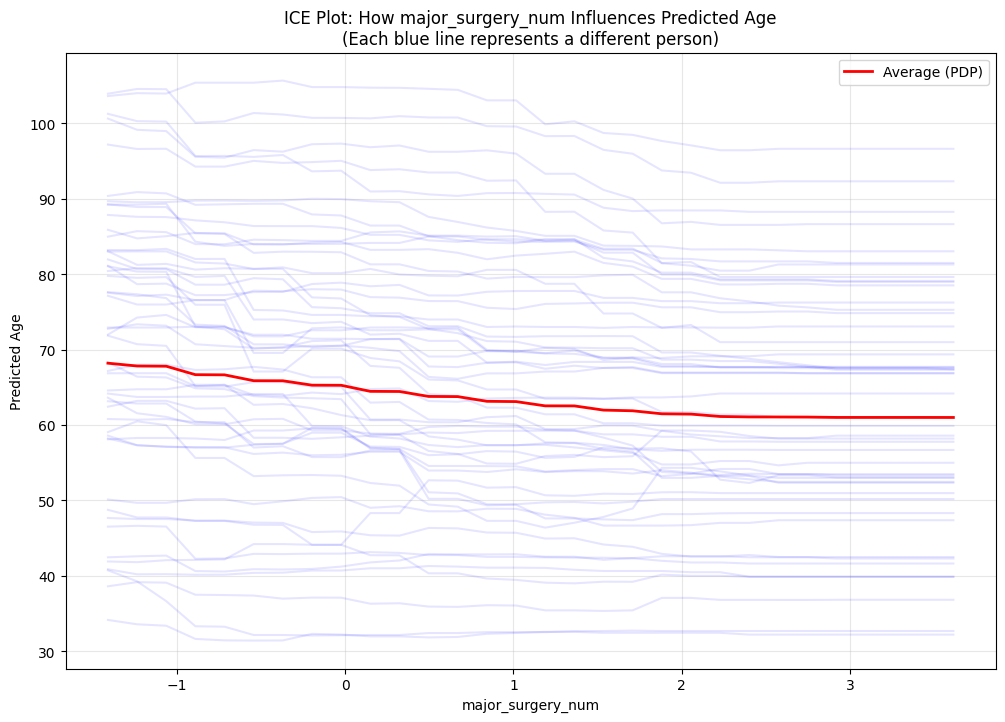

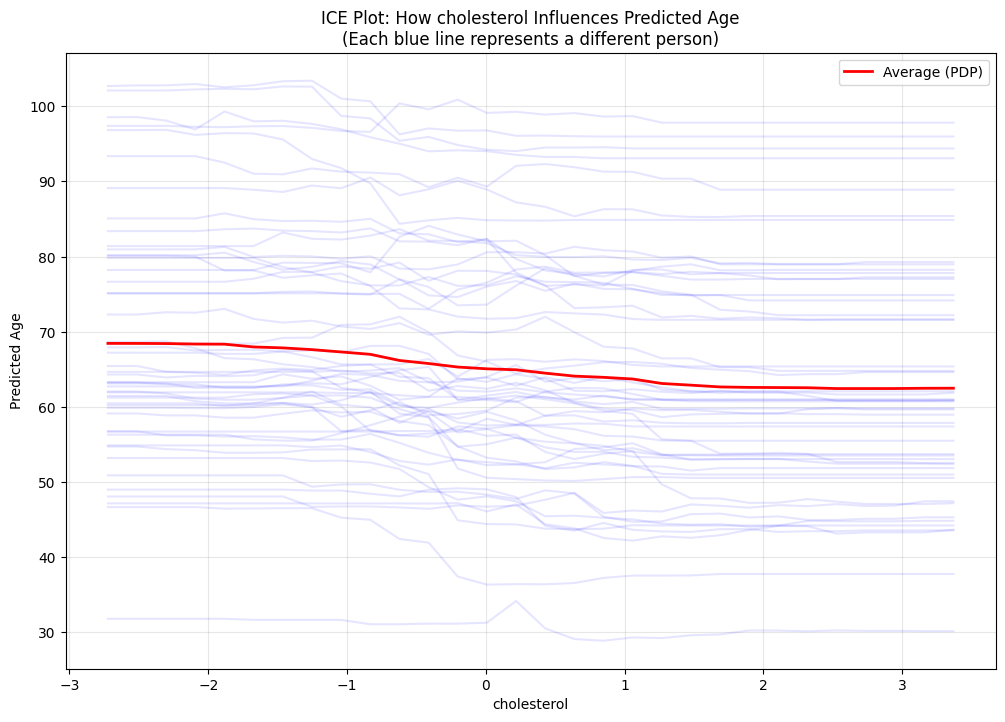

In [185]:
def create_feature_ice_plots(model, X_array, feature_names, feature_idx, num_ice_lines=50, figsize=(12, 8)):
    """
    Create ICE plot showing how predictions change with different feature values

    Parameters:
    -----------
    model : RandomForestRegressor
        Fitted random forest model
    X_array : numpy array
        The dataset containing all features
    feature_names : list
        List of feature names
    feature_idx : int
        Index of the feature to analyze
    num_ice_lines : int
        Number of instances to plot
    figsize : tuple
        Size of the figure
    """
    plt.figure(figsize=figsize)

    feature_name = feature_names[feature_idx]

    # Create feature grid points
    feature_min = X_array[:, feature_idx].min()
    feature_max = X_array[:, feature_idx].max()
    feature_grid = np.linspace(feature_min, feature_max, num=30)

    # Randomly sample instances
    sample_indices = np.random.choice(len(X_array), size=num_ice_lines, replace=False)

    # Plot ICE lines for sampled instances
    for idx in sample_indices:
        instance = X_array[idx].copy()
        predictions = []

        # Calculate predictions across feature range
        for feature_val in feature_grid:
            instance_copy = instance.copy()
            instance_copy[feature_idx] = feature_val
            pred = model.predict(instance_copy.reshape(1, -1))
            predictions.append(pred[0])

        plt.plot(feature_grid, predictions, alpha=0.1, color='blue')

    # Calculate and plot PDP (average prediction across all instances)
    pdp_predictions = []
    for feature_val in feature_grid:
        X_temp = X_array.copy()
        X_temp[:, feature_idx] = feature_val
        preds = model.predict(X_temp)
        pdp_predictions.append(np.mean(preds))

    plt.plot(feature_grid, pdp_predictions, color='red', linewidth=2, label='Average (PDP)')

    # Add labels and formatting
    plt.xlabel(feature_name)
    plt.ylabel('Predicted Age')
    plt.title(f'ICE Plot: How {feature_name} Influences Predicted Age\n(Each blue line represents a different person)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    return plt

# Feature names in correct order
feature_names = [
    'weight', 'height', 'sys_bp', 'num_meds', 'occup_danger', 'ls_danger',
    'drinks_aweek', 'major_surgery_num', 'cholesterol', 'sex_m', 'smoker_y',
    'nic_other_y', 'cannabis_y', 'opioids_y', 'other_drugs_y', 'addiction_y',
    'diabetes_y', 'hds_y', 'asthma_y', 'immune_defic_y', 'family_cancer_y',
    'family_heart_disease_y', 'family_cholesterol_y'
]

# Selected numerical features and their indices
numerical_features = {
    'weight': 0,
    'height': 1,
    'sys_bp': 2,
    'num_meds': 3,
    'drinks_aweek': 6,
    'major_surgery_num': 7,
    'cholesterol': 8
}

# Create plot for each feature
for feature_name, feature_idx in numerical_features.items():
    try:
        plot = create_feature_ice_plots(rf_model, X_test_scaled, feature_names, feature_idx)
        plt.show()
    except Exception as e:
        print(f"Error creating plot for {feature_name}: {str(e)}")
        #Source: https://claude.site/artifacts/20acbbcd-f045-40c7-8a7f-539900e46b25

#Ice Plot with GAM

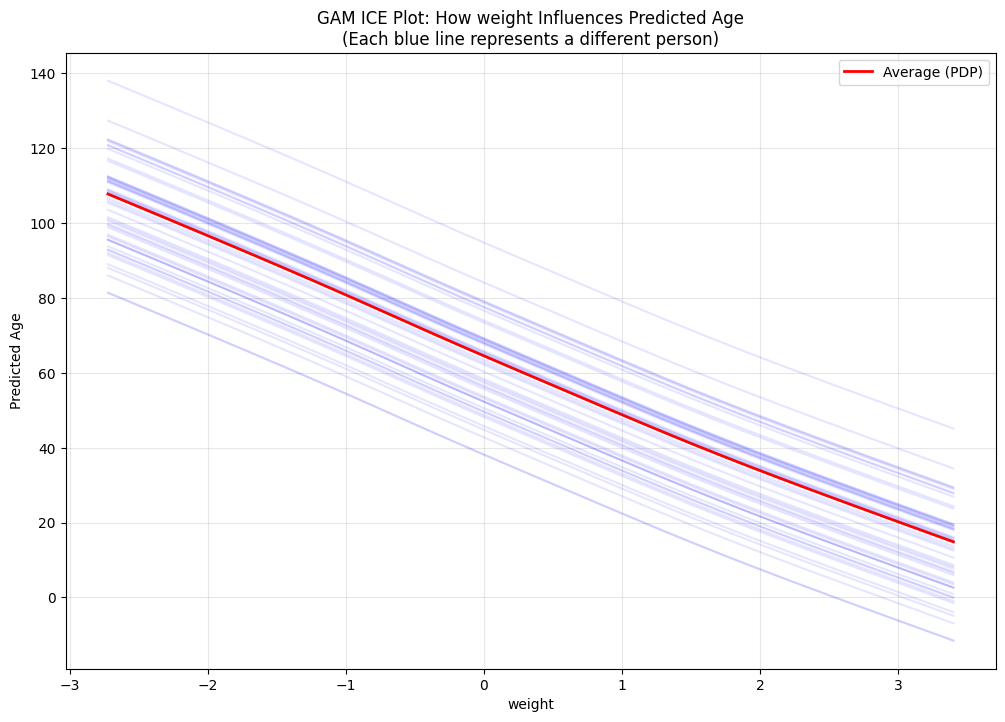

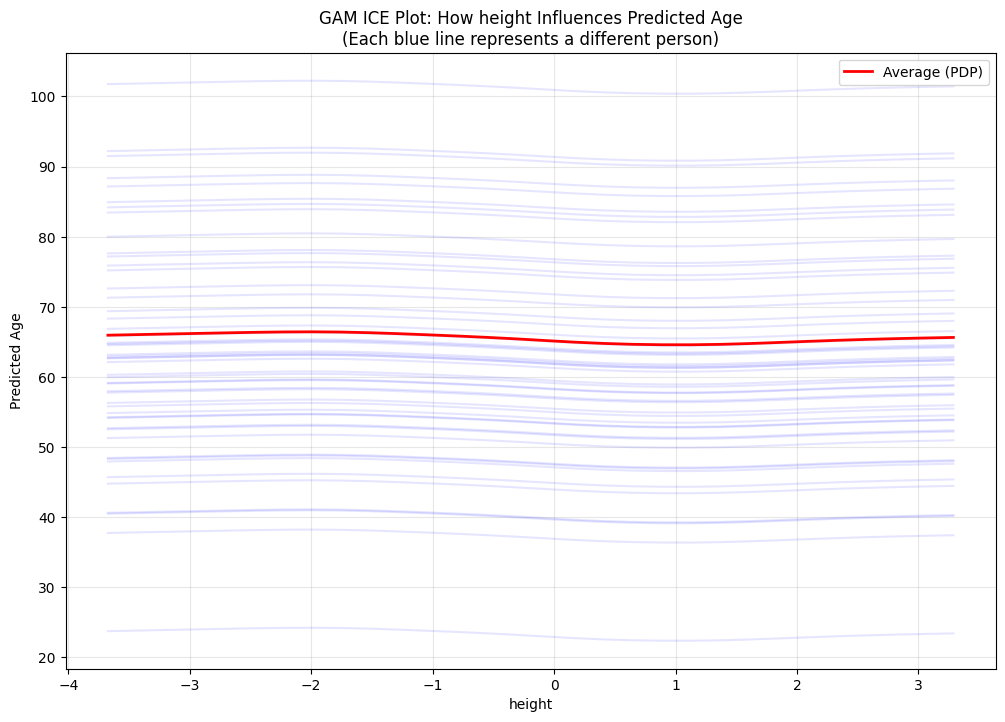

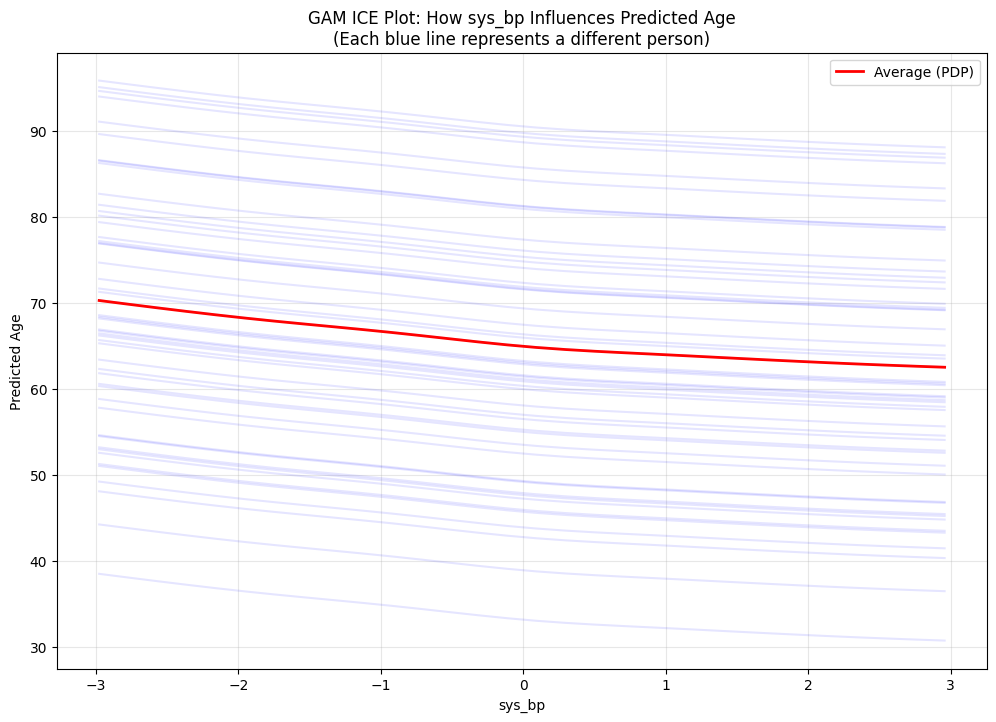

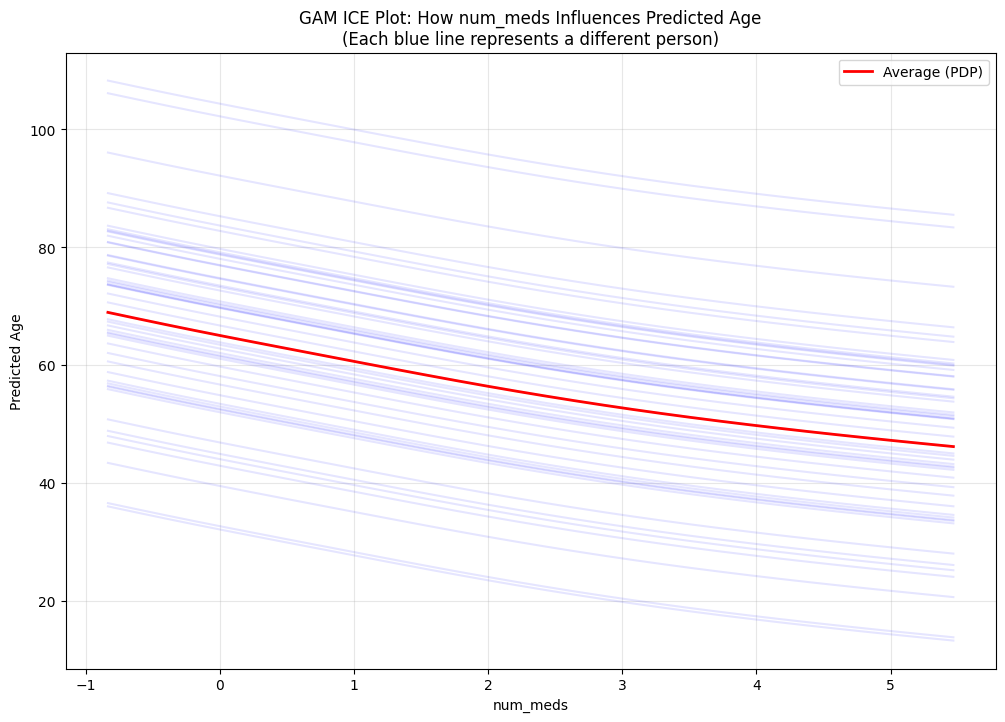

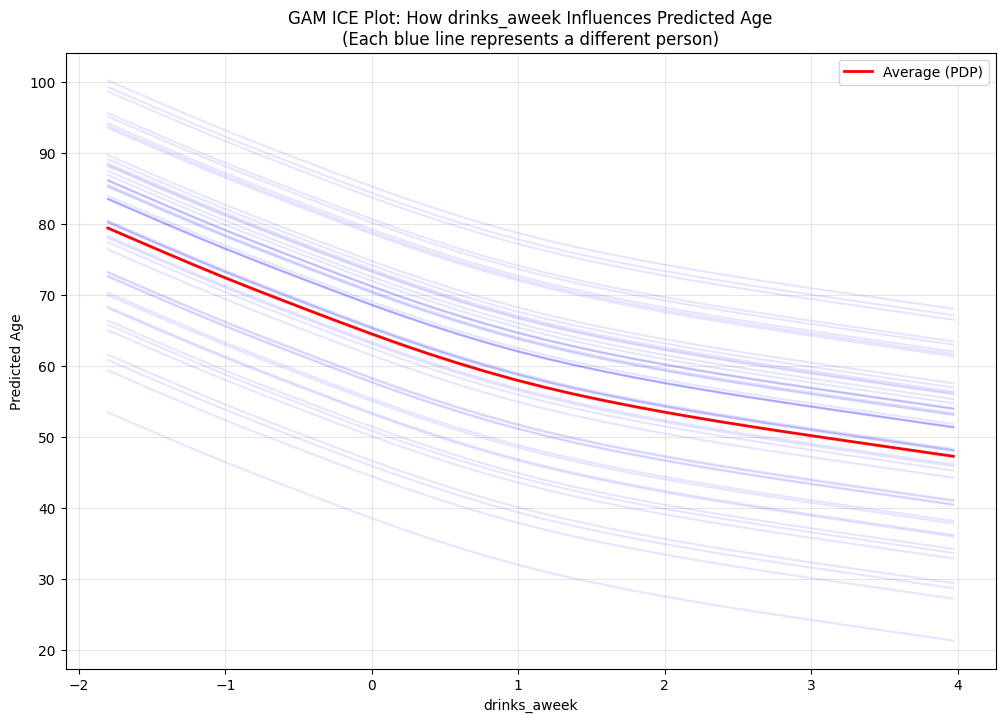

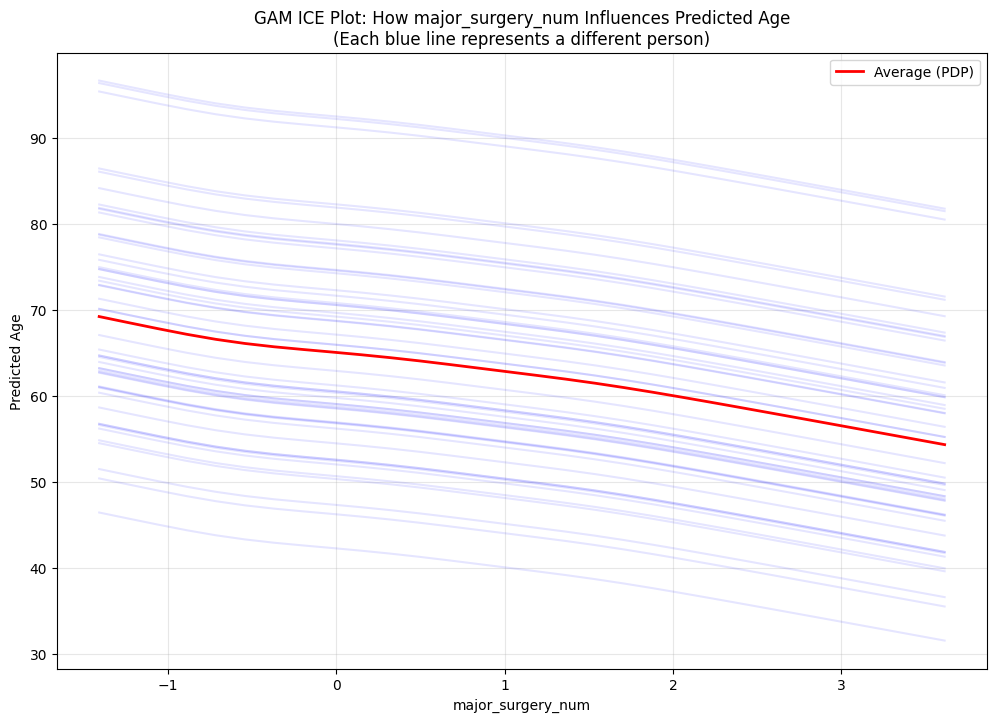

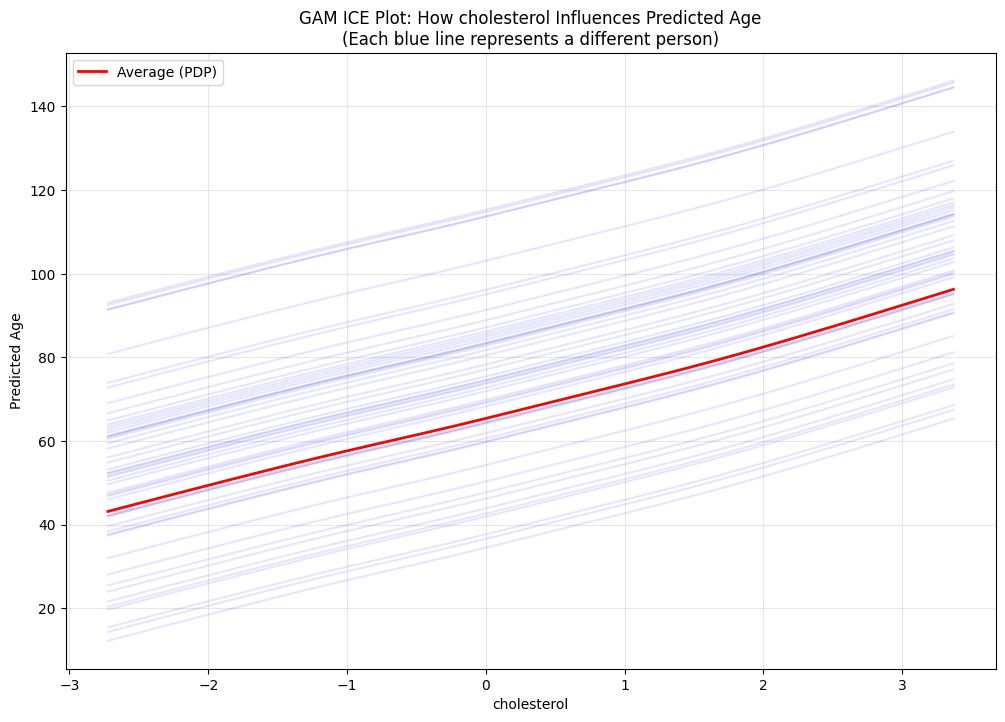

In [178]:
def create_feature_ice_plots(model, X_array, feature_names, feature_idx, num_ice_lines=50, figsize=(12, 8)):
    """
    Create ICE plot showing how GAM predictions change with different feature values

    Parameters:
    -----------
    model : LinearGAM
        Fitted GAM model
    X_array : numpy array
        The dataset containing all features
    feature_names : list
        List of feature names
    feature_idx : int
        Index of the feature to analyze
    num_ice_lines : int
        Number of instances to plot
    figsize : tuple
        Size of the figure
    """
    plt.figure(figsize=figsize)

    feature_name = feature_names[feature_idx]

    # Create feature grid points
    feature_min = X_array[:, feature_idx].min()
    feature_max = X_array[:, feature_idx].max()
    feature_grid = np.linspace(feature_min, feature_max, num=30)

    # Randomly sample instances
    sample_indices = np.random.choice(len(X_array), size=num_ice_lines, replace=False)

    # Plot ICE lines for sampled instances
    for idx in sample_indices:
        instance = X_array[idx].copy()
        predictions = []

        # Calculate predictions across feature range
        for feature_val in feature_grid:
            instance_copy = instance.copy()
            instance_copy[feature_idx] = feature_val
            pred = model.predict(instance_copy.reshape(1, -1))
            predictions.append(pred[0])

        plt.plot(feature_grid, predictions, alpha=0.1, color='blue')

    # Calculate and plot PDP (average prediction across all instances)
    pdp_predictions = []
    for feature_val in feature_grid:
        X_temp = X_array.copy()
        X_temp[:, feature_idx] = feature_val
        preds = model.predict(X_temp)
        pdp_predictions.append(np.mean(preds))

    plt.plot(feature_grid, pdp_predictions, color='red', linewidth=2, label='Average (PDP)')

    # Add labels and formatting
    plt.xlabel(feature_name)
    plt.ylabel('Predicted Age')
    plt.title(f'GAM ICE Plot: How {feature_name} Influences Predicted Age\n(Each blue line represents a different person)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    return plt

# Feature names in correct order
feature_names = [
    'weight', 'height', 'sys_bp', 'num_meds', 'occup_danger', 'ls_danger',
    'drinks_aweek', 'major_surgery_num', 'cholesterol', 'sex_m', 'smoker_y',
    'nic_other_y', 'cannabis_y', 'opioids_y', 'other_drugs_y', 'addiction_y',
    'diabetes_y', 'hds_y', 'asthma_y', 'immune_defic_y', 'family_cancer_y',
    'family_heart_disease_y', 'family_cholesterol_y'
]

# Selected numerical features and their indices
numerical_features = {
    'weight': 0,
    'height': 1,
    'sys_bp': 2,
    'num_meds': 3,
    'drinks_aweek': 6,
    'major_surgery_num': 7,
    'cholesterol': 8
}

# Create plot for each feature
for feature_name, feature_idx in numerical_features.items():
    try:
        plot = create_feature_ice_plots(gam, X_test_scaled, feature_names, feature_idx)
        plt.show()
    except Exception as e:
        print(f"Error creating plot for {feature_name}: {str(e)}")

It appears that weight has the strongest impact on mortality - a higher weight is associated with a lower age of death. The second most impactful is drinks per week. According to Claude, moving from -2 to 4 drinks/week shows roughly a 30-year decrease in lifespan. At a glance, it looks pretty similar to the ICE plot showing the number of major surgeries.

I was surprised that high cholesterol is associated with longer lifetimes. This could indicate there is something that we are missing, or something that is being mis-measured. Additionally, the number of medications could be associated with younger deaths because of underlying health conditions and not the meds themselves.

Collaborated with Claude Sonnet 3.5 02/06/2025 1:09 am

#ALE Plot

In [203]:
pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-e097i76l/alepython_4bd5aca422554496b1b5320af8f90971
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-e097i76l/alepython_4bd5aca422554496b1b5320af8f90971
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done


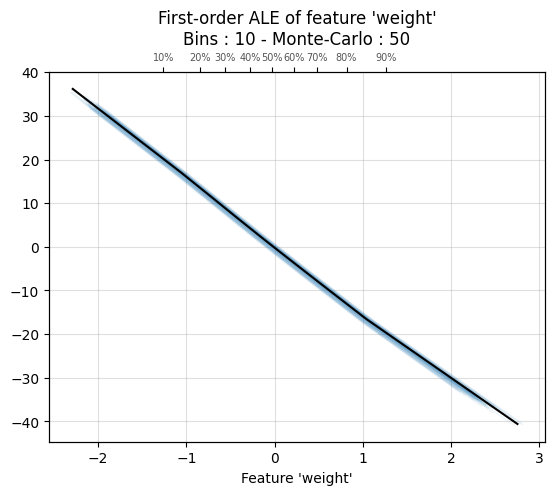

<Axes: title={'center': "First-order ALE of feature 'weight'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'weight'">

In [237]:
# Create DataFrame with scaled features - using your existing X_train_scaled
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Now use the scaled dataframe for the ALE plot - without additional plt commands
ale_plot(gam, X_train_df, 'weight', monte_carlo=True)

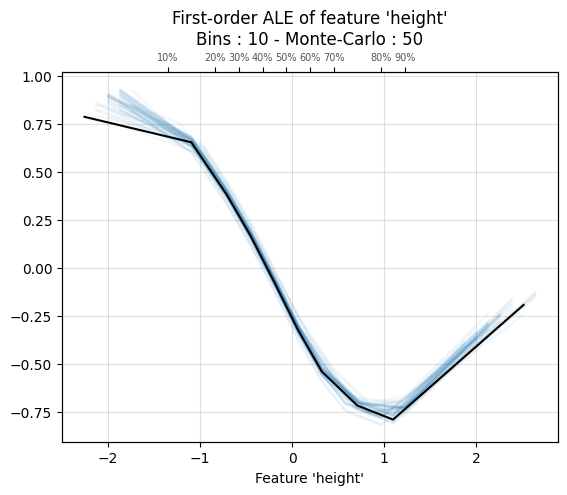

<Axes: title={'center': "First-order ALE of feature 'height'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'height'">

In [231]:
# Create DataFrame with scaled features - using your existing X_train_scaled
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Now use the scaled dataframe for the ALE plot - without additional plt commands
ale_plot(gam, X_train_df, 'height', monte_carlo=True)

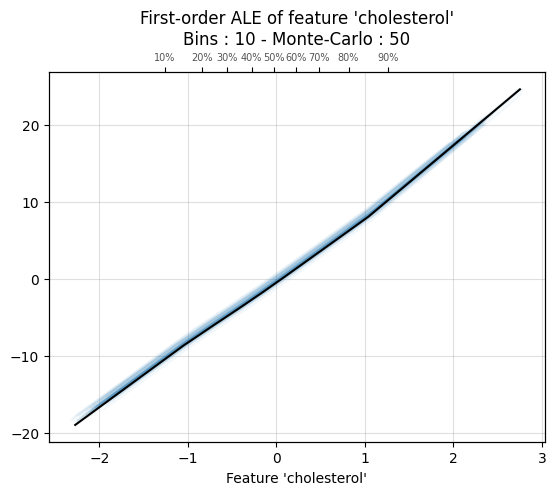

<Axes: title={'center': "First-order ALE of feature 'cholesterol'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'cholesterol'">

In [233]:
# Create DataFrame with scaled features - using your existing X_train_scaled
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Now use the scaled dataframe for the ALE plot - without additional plt commands
ale_plot(gam, X_train_df, 'cholesterol', monte_carlo=True)

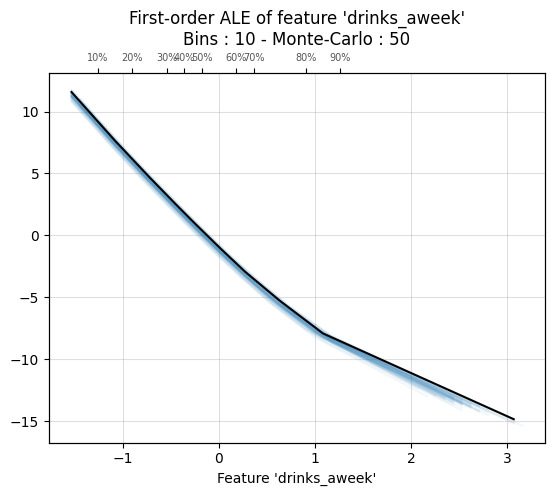

<Axes: title={'center': "First-order ALE of feature 'drinks_aweek'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'drinks_aweek'">

In [235]:
# Create DataFrame with scaled features - using your existing X_train_scaled
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Now use the scaled dataframe for the ALE plot - without additional plt commands
ale_plot(gam, X_train_df, 'drinks_aweek', monte_carlo=True)

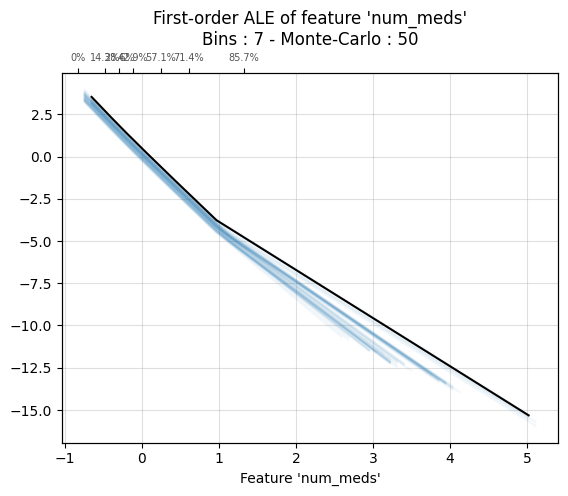

<Axes: title={'center': "First-order ALE of feature 'num_meds'\nBins : 7 - Monte-Carlo : 50"}, xlabel="Feature 'num_meds'">

In [238]:
# Create DataFrame with scaled features - using your existing X_train_scaled
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Now use the scaled dataframe for the ALE plot - without additional plt commands
ale_plot(gam, X_train_df, 'num_meds', monte_carlo=True)